# Importing libraries

In [7]:
# Importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Data preparation

In [8]:
# Reading the data
df = pd.read_csv("tweets.csv", sep=",")
# Dropping the unnecessary features
df.drop(["selected_text", "textID"], axis=1, inplace=True)
# Dropping the rows with missing values
df.dropna(inplace=True)
# Dropping the rows with neutral sentiment
df = df[df["sentiment"] != "neutral"]
# Converting the sentiment to binary
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

df.head()

,text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
6,2am feedings for the baby are fun when he is a...,1


# Splitting data

In [9]:
# Splitting the data to train and test
texts = df['text']  
labels = df['sentiment']  
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorizing the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Applying models
## Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_nb = nb_model.predict(X_test_vec)
nb_classification_report = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

Naive Bayes:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      1603
           1       0.84      0.89      0.87      1670

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
weighted avg       0.86      0.86      0.86      3273



## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Training the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
lr_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_lr = lr_model.predict(X_test_vec)
lr_classification_report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
print("Logistic regression:\n", classification_report(y_test, y_pred_lr))

Logistic regression:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1603
           1       0.88      0.88      0.88      1670

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_rf = rf_model.predict(X_test_vec)
rf_clasification_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1603
           1       0.88      0.83      0.86      1670

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
weighted avg       0.86      0.86      0.86      3273



## SVC

In [13]:
from sklearn.svm import SVC

# Training the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_svm = svm_model.predict(X_test_vec)
svm_classification_report = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1603
           1       0.88      0.88      0.88      1670

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



## Bert

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# Initializing the tokenizer and the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
y_pred_bert = []
# This function calculates the roberta sentiment scores and returns them as a dictionary
def polarity_scores(text):
    text = text[:512]
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    if scores[0] > scores[2]:
        y_pred_bert.append(0)
    else:    
        y_pred_bert.append(1)

In [16]:
X_test.apply(polarity_scores)
bert_classification_report = classification_report(y_test, y_pred_bert, output_dict=True, zero_division=0)
print("BERT:\n", classification_report(y_test, y_pred_bert))

BERT:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      1603
           1       0.91      0.94      0.92      1670

    accuracy                           0.92      3273
   macro avg       0.92      0.92      0.92      3273
weighted avg       0.92      0.92      0.92      3273



# Comparing results
## Precision-Recall Curve

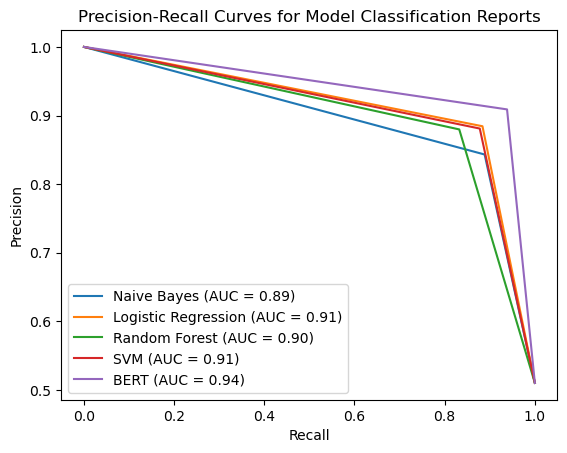

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate the precision-recall curves for each model
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
precision_bert, recall_bert, _ = precision_recall_curve(y_test, y_pred_bert)

# Calculate the area under the precision-recall curve for each model
auc_nb = auc(recall_nb, precision_nb)
auc_lr = auc(recall_lr, precision_lr)
auc_rf = auc(recall_rf, precision_rf)
auc_svm = auc(recall_svm, precision_svm)
auc_bert = auc(recall_bert, precision_bert)

# Plot the precision-recall curves
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {auc_bert:.2f})')

# Set the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## ROC Curve

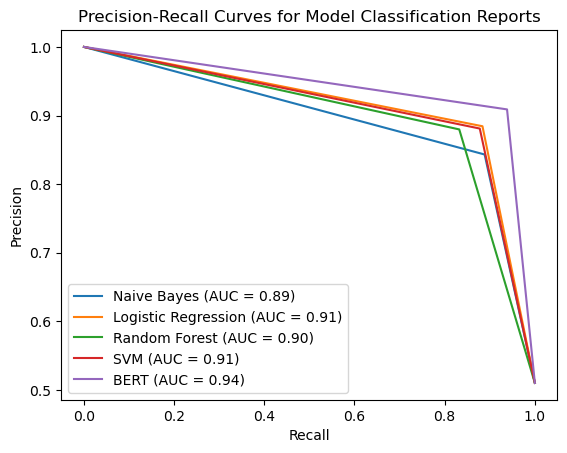

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate the precision-recall curves for each model
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
precision_bert, recall_bert, _ = precision_recall_curve(y_test, y_pred_bert)

# Calculate the area under the precision-recall curve for each model
auc_nb = auc(recall_nb, precision_nb)
auc_lr = auc(recall_lr, precision_lr)
auc_rf = auc(recall_rf, precision_rf)
auc_svm = auc(recall_svm, precision_svm)
auc_bert = auc(recall_bert, precision_bert)

# Plot the precision-recall curves
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {auc_bert:.2f})')

# Set the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Accuracies

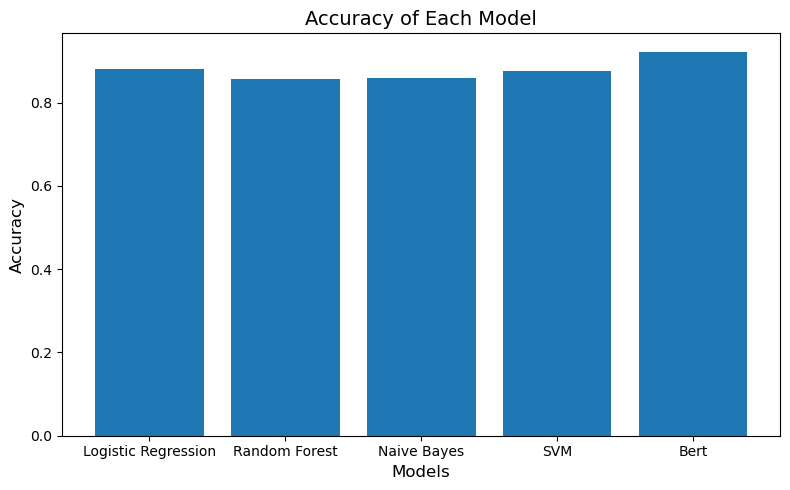

In [19]:
import matplotlib.pyplot as plt

# Example accuracies (use the actual ones you've calculated)
accuracies = {
    "Logistic Regression": lr_classification_report["accuracy"],
    "Random Forest": rf_clasification_report["accuracy"],
    "Naive Bayes": nb_classification_report["accuracy"],
    "SVM": svm_classification_report["accuracy"],
    "Bert": bert_classification_report["accuracy"],
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(accuracies.keys(), accuracies.values())

# Customizing the plot
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy of Each Model", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

In [4]:
data = [
    {"type":"Feature","id":"01","properties":{"name":"Alabama","density":94.65},"geometry":{"type":"Polygon","coordinates":[[[-87.359296,35.00118],[-85.606675,34.984749],[-85.431413,34.124869],[-85.184951,32.859696],[-85.069935,32.580372],[-84.960397,32.421541],[-85.004212,32.322956],[-84.889196,32.262709],[-85.058981,32.13674],[-85.053504,32.01077],[-85.141136,31.840985],[-85.042551,31.539753],[-85.113751,31.27686],[-85.004212,31.003013],[-85.497137,30.997536],[-87.600282,30.997536],[-87.633143,30.86609],[-87.408589,30.674397],[-87.446927,30.510088],[-87.37025,30.427934],[-87.518128,30.280057],[-87.655051,30.247195],[-87.90699,30.411504],[-87.934375,30.657966],[-88.011052,30.685351],[-88.10416,30.499135],[-88.137022,30.318396],[-88.394438,30.367688],[-88.471115,31.895754],[-88.241084,33.796253],[-88.098683,34.891641],[-88.202745,34.995703],[-87.359296,35.00118]]]}},
    {"type":"Feature","id":"02","properties":{"name":"Alaska","density":1.264},"geometry":{"type":"MultiPolygon","coordinates":[[[[-131.602021,55.117982],[-131.569159,55.28229],[-131.355558,55.183705],[-131.38842,55.01392],[-131.645836,55.035827],[-131.602021,55.117982]]],[[[-131.832052,55.42469],[-131.645836,55.304197],[-131.749898,55.128935],[-131.832052,55.189182],[-131.832052,55.42469]]],[[[-132.976733,56.437924],[-132.735747,56.459832],[-132.631685,56.421493],[-132.664547,56.273616],[-132.878148,56.240754],[-133.069841,56.333862],[-132.976733,56.437924]]],[[[-133.595627,56.350293],[-133.162949,56.317431],[-133.05341,56.125739],[-132.620732,55.912138],[-132.472854,55.780691],[-132.4619,55.671152],[-132.357838,55.649245],[-132.341408,55.506844],[-132.166146,55.364444],[-132.144238,55.238474],[-132.029222,55.276813],[-131.97993,55.178228],[-131.958022,54.789365],[-132.029222,54.701734],[-132.308546,54.718165],[-132.385223,54.915335],[-132.483808,54.898904],[-132.686455,55.046781],[-132.746701,54.997489],[-132.916486,55.046781],[-132.889102,54.898904],[-132.73027,54.937242],[-132.626209,54.882473],[-132.675501,54.679826],[-132.867194,54.701734],[-133.157472,54.95915],[-133.239626,55.090597],[-133.223195,55.22752],[-133.453227,55.216566],[-133.453227,55.320628],[-133.277964,55.331582],[-133.102702,55.42469],[-133.17938,55.588998],[-133.387503,55.62186],[-133.420365,55.884753],[-133.497042,56.0162],[-133.639442,55.923092],[-133.694212,56.070969],[-133.546335,56.142169],[-133.666827,56.311955],[-133.595627,56.350293]]],[[[-133.738027,55.556137],[-133.546335,55.490413],[-133.414888,55.572568],[-133.283441,55.534229],[-133.420365,55.386352],[-133.633966,55.430167],[-133.738027,55.556137]]],[[[-133.907813,56.930849],[-134.050213,57.029434],[-133.885905,57.095157],[-133.343688,57.002049],[-133.102702,57.007526],[-132.932917,56.82131],[-132.620732,56.667956],[-132.653593,56.55294],[-132.817901,56.492694],[-133.042456,56.520078],[-133.201287,56.448878],[-133.420365,56.492694],[-133.66135,56.448878],[-133.710643,56.684386],[-133.688735,56.837741],[-133.869474,56.843218],[-133.907813,56.930849]]],[[[-134.115936,56.48174],[-134.25286,56.558417],[-134.400737,56.722725],[-134.417168,56.848695],[-134.296675,56.908941],[-134.170706,56.848695],[-134.143321,56.952757],[-133.748981,56.772017],[-133.710643,56.596755],[-133.847566,56.574848],[-133.935197,56.377678],[-133.836612,56.322908],[-133.957105,56.092877],[-134.110459,56.142169],[-134.132367,55.999769],[-134.230952,56.070969],[-134.291198,56.350293],[-134.115936,56.48174]]],[[[-134.636246,56.28457],[-134.669107,56.169554],[-134.806031,56.235277],[-135.178463,56.67891],[-135.413971,56.810356],[-135.331817,56.914418],[-135.424925,57.166357],[-135.687818,57.369004],[-135.419448,57.566174],[-135.298955,57.48402],[-135.063447,57.418296],[-134.849846,57.407343],[-134.844369,57.248511],[-134.636246,56.728202],[-134.636246,56.28457]]],[[[-134.712923,58.223407],[-134.373353,58.14673],[-134.176183,58.157683],[-134.187137,58.081006],[-133.902336,57.807159],[-134.099505,57.850975],[-134.148798,57.757867],[-133.935197,57.615466],[-133.869474,57.363527],[-134.083075,57.297804],[-134.154275,57.210173],[-134.499322,57.029434],[-134.603384,57.034911],[-134.6472,57.226604],[-134.575999,57.341619],[-134.608861,57.511404],[-134.729354,57.719528],[-134.707446,57.829067],[-134.784123,58.097437],[-134.91557,58.212453],[-134.953908,58.409623],[-134.712923,58.223407]]],[[[-135.857603,57.330665],[-135.715203,57.330665],[-135.567326,57.149926],[-135.633049,57.023957],[-135.857603,56.996572],[-135.824742,57.193742],[-135.857603,57.330665]]],[[[-136.279328,58.206976],[-135.978096,58.201499],[-135.780926,58.28913],[-135.496125,58.168637],[-135.64948,58.037191],[-135.59471,57.987898],[-135.45231,58.135776],[-135.107263,58.086483],[-134.91557,57.976944],[-135.025108,57.779775],[-134.937477,57.763344],[-134.822462,57.500451],[-135.085355,57.462112],[-135.572802,57.675713],[-135.556372,57.456635],[-135.709726,57.369004],[-135.890465,57.407343],[-136.000004,57.544266],[-136.208128,57.637374],[-136.366959,57.829067],[-136.569606,57.916698],[-136.558652,58.075529],[-136.421728,58.130299],[-136.377913,58.267222],[-136.279328,58.206976]]],[[[-147.079854,60.200582],[-147.501579,59.948643],[-147.53444,59.850058],[-147.874011,59.784335],[-147.80281,59.937689],[-147.435855,60.09652],[-147.205824,60.271782],[-147.079854,60.200582]]],[[[-147.561825,60.578491],[-147.616594,60.370367],[-147.758995,60.156767],[-147.956165,60.227967],[-147.791856,60.474429],[-147.561825,60.578491]]],[[[-147.786379,70.245291],[-147.682318,70.201475],[-147.162008,70.15766],[-146.888161,70.185044],[-146.510252,70.185044],[-146.099482,70.146706],[-145.858496,70.168614],[-145.622988,70.08646],[-145.195787,69.993352],[-144.620708,69.971444],[-144.461877,70.026213],[-144.078491,70.059075],[-143.914183,70.130275],[-143.497935,70.141229],[-143.503412,70.091936],[-143.25695,70.119321],[-142.747594,70.042644],[-142.402547,69.916674],[-142.079408,69.856428],[-142.008207,69.801659],[-141.712453,69.790705],[-141.433129,69.697597],[-141.378359,69.63735],[-141.208574,69.686643],[-141.00045,69.648304],[-141.00045,60.304644],[-140.53491,60.22249],[-140.474664,60.310121],[-139.987216,60.184151],[-139.696939,60.342983],[-139.088998,60.359413],[-139.198537,60.091043],[-139.045183,59.997935],[-138.700135,59.910304],[-138.623458,59.767904],[-137.604747,59.242118],[-137.445916,58.908024],[-137.265177,59.001132],[-136.827022,59.159963],[-136.580559,59.16544],[-136.465544,59.285933],[-136.476498,59.466672],[-136.301236,59.466672],[-136.25742,59.625503],[-135.945234,59.663842],[-135.479694,59.800766],[-135.025108,59.565257],[-135.068924,59.422857],[-134.959385,59.280456],[-134.701969,59.247595],[-134.378829,59.033994],[-134.400737,58.973748],[-134.25286,58.858732],[-133.842089,58.727285],[-133.173903,58.152206],[-133.075318,57.998852],[-132.867194,57.845498],[-132.560485,57.505928],[-132.253777,57.21565],[-132.368792,57.095157],[-132.05113,57.051341],[-132.127807,56.876079],[-131.870391,56.804879],[-131.837529,56.602232],[-131.580113,56.613186],[-131.087188,56.405062],[-130.78048,56.366724],[-130.621648,56.268139],[-130.468294,56.240754],[-130.424478,56.142169],[-130.101339,56.114785],[-130.002754,55.994292],[-130.150631,55.769737],[-130.128724,55.583521],[-129.986323,55.276813],[-130.095862,55.200136],[-130.336847,54.920812],[-130.687372,54.718165],[-130.785957,54.822227],[-130.917403,54.789365],[-131.010511,54.997489],[-130.983126,55.08512],[-131.092665,55.189182],[-130.862634,55.298721],[-130.928357,55.337059],[-131.158389,55.200136],[-131.284358,55.287767],[-131.426759,55.238474],[-131.843006,55.457552],[-131.700606,55.698537],[-131.963499,55.616383],[-131.974453,55.49589],[-132.182576,55.588998],[-132.226392,55.704014],[-132.083991,55.829984],[-132.127807,55.955953],[-132.324977,55.851892],[-132.522147,56.076446],[-132.642639,56.032631],[-132.719317,56.218847],[-132.527624,56.339339],[-132.341408,56.339339],[-132.396177,56.487217],[-132.297592,56.67891],[-132.450946,56.673433],[-132.768609,56.837741],[-132.993164,57.034911],[-133.51895,57.177311],[-133.507996,57.577128],[-133.677781,57.62642],[-133.639442,57.790728],[-133.814705,57.834544],[-134.072121,58.053622],[-134.143321,58.168637],[-134.586953,58.206976],[-135.074401,58.502731],[-135.282525,59.192825],[-135.38111,59.033994],[-135.337294,58.891593],[-135.140124,58.617746],[-135.189417,58.573931],[-135.05797,58.349376],[-135.085355,58.201499],[-135.277048,58.234361],[-135.430402,58.398669],[-135.633049,58.426053],[-135.91785,58.382238],[-135.912373,58.617746],[-136.087635,58.814916],[-136.246466,58.75467],[-136.876314,58.962794],[-136.931084,58.902547],[-136.586036,58.836824],[-136.317666,58.672516],[-136.213604,58.667039],[-136.180743,58.535592],[-136.043819,58.382238],[-136.388867,58.294607],[-136.591513,58.349376],[-136.59699,58.212453],[-136.859883,58.316515],[-136.947514,58.393192],[-137.111823,58.393192],[-137.566409,58.590362],[-137.900502,58.765624],[-137.933364,58.869686],[-138.11958,59.02304],[-138.634412,59.132579],[-138.919213,59.247595],[-139.417615,59.379041],[-139.746231,59.505011],[-139.718846,59.641934],[-139.625738,59.598119],[-139.5162,59.68575],[-139.625738,59.88292],[-139.488815,59.992458],[-139.554538,60.041751],[-139.801,59.833627],[-140.315833,59.696704],[-140.92925,59.745996],[-141.444083,59.871966],[-141.46599,59.970551],[-141.706976,59.948643],[-141.964392,60.019843],[-142.539471,60.085566],[-142.873564,60.091043],[-143.623905,60.036274],[-143.892275,59.997935],[-144.231845,60.140336],[-144.65357,60.206059],[-144.785016,60.29369],[-144.834309,60.441568],[-145.124586,60.430614],[-145.223171,60.299167],[-145.738004,60.474429],[-145.820158,60.551106],[-146.351421,60.408706],[-146.608837,60.238921],[-146.718376,60.397752],[-146.608837,60.485383],[-146.455483,60.463475],[-145.951604,60.578491],[-146.017328,60.666122],[-146.252836,60.622307],[-146.345944,60.737322],[-146.565022,60.753753],[-146.784099,61.044031],[-146.866253,60.972831],[-147.172962,60.934492],[-147.271547,60.972831],[-147.375609,60.879723],[-147.758995,60.912584],[-147.775426,60.808523],[-148.032842,60.781138],[-148.153334,60.819476],[-148.065703,61.005692],[-148.175242,61.000215],[-148.350504,60.803046],[-148.109519,60.737322],[-148.087611,60.594922],[-147.939734,60.441568],[-148.027365,60.277259],[-148.219058,60.332029],[-148.273827,60.249875],[-148.087611,60.217013],[-147.983549,59.997935],[-148.251919,59.95412],[-148.399797,59.997935],[-148.635305,59.937689],[-148.755798,59.986981],[-149.067984,59.981505],[-149.05703,60.063659],[-149.204907,60.008889],[-149.287061,59.904827],[-149.418508,59.997935],[-149.582816,59.866489],[-149.511616,59.806242],[-149.741647,59.729565],[-149.949771,59.718611],[-150.031925,59.61455],[-150.25648,59.521442],[-150.409834,59.554303],[-150.579619,59.444764],[-150.716543,59.450241],[-151.001343,59.225687],[-151.308052,59.209256],[-151.406637,59.280456],[-151.592853,59.159963],[-151.976239,59.253071],[-151.888608,59.422857],[-151.636669,59.483103],[-151.47236,59.472149],[-151.423068,59.537872],[-151.127313,59.669319],[-151.116359,59.778858],[-151.505222,59.63098],[-151.828361,59.718611],[-151.8667,59.778858],[-151.702392,60.030797],[-151.423068,60.211536],[-151.379252,60.359413],[-151.297098,60.386798],[-151.264237,60.545629],[-151.406637,60.720892],[-151.06159,60.786615],[-150.404357,61.038554],[-150.245526,60.939969],[-150.042879,60.912584],[-149.741647,61.016646],[-150.075741,61.15357],[-150.207187,61.257632],[-150.47008,61.246678],[-150.656296,61.29597],[-150.711066,61.252155],[-151.023251,61.180954],[-151.165652,61.044031],[-151.477837,61.011169],[-151.800977,60.852338],[-151.833838,60.748276],[-152.080301,60.693507],[-152.13507,60.578491],[-152.310332,60.507291],[-152.392486,60.304644],[-152.732057,60.173197],[-152.567748,60.069136],[-152.704672,59.915781],[-153.022334,59.888397],[-153.049719,59.691227],[-153.345474,59.620026],[-153.438582,59.702181],[-153.586459,59.548826],[-153.761721,59.543349],[-153.72886,59.433811],[-154.117723,59.368087],[-154.1944,59.066856],[-153.750768,59.050425],[-153.400243,58.968271],[-153.301658,58.869686],[-153.444059,58.710854],[-153.679567,58.612269],[-153.898645,58.606793],[-153.920553,58.519161],[-154.062953,58.4863],[-153.99723,58.376761],[-154.145107,58.212453],[-154.46277,58.059098],[-154.643509,58.059098],[-154.818771,58.004329],[-154.988556,58.015283],[-155.120003,57.955037],[-155.081664,57.872883],[-155.328126,57.829067],[-155.377419,57.708574],[-155.547204,57.785251],[-155.73342,57.549743],[-156.045606,57.566174],[-156.023698,57.440204],[-156.209914,57.473066],[-156.34136,57.418296],[-156.34136,57.248511],[-156.549484,56.985618],[-156.883577,56.952757],[-157.157424,56.832264],[-157.20124,56.766541],[-157.376502,56.859649],[-157.672257,56.607709],[-157.754411,56.67891],[-157.918719,56.657002],[-157.957058,56.514601],[-158.126843,56.459832],[-158.32949,56.48174],[-158.488321,56.339339],[-158.208997,56.295524],[-158.510229,55.977861],[-159.375585,55.873799],[-159.616571,55.594475],[-159.676817,55.654722],[-159.643955,55.829984],[-159.813741,55.857368],[-160.027341,55.791645],[-160.060203,55.720445],[-160.394296,55.605429],[-160.536697,55.473983],[-160.580512,55.567091],[-160.668143,55.457552],[-160.865313,55.528752],[-161.232268,55.358967],[-161.506115,55.364444],[-161.467776,55.49589],[-161.588269,55.62186],[-161.697808,55.517798],[-161.686854,55.408259],[-162.053809,55.074166],[-162.179779,55.15632],[-162.218117,55.03035],[-162.470057,55.052258],[-162.508395,55.249428],[-162.661749,55.293244],[-162.716519,55.222043],[-162.579595,55.134412],[-162.645319,54.997489],[-162.847965,54.926289],[-163.00132,55.079643],[-163.187536,55.090597],[-163.220397,55.03035],[-163.034181,54.942719],[-163.373752,54.800319],[-163.14372,54.76198],[-163.138243,54.696257],[-163.329936,54.74555],[-163.587352,54.614103],[-164.085754,54.61958],[-164.332216,54.531949],[-164.354124,54.466226],[-164.638925,54.389548],[-164.847049,54.416933],[-164.918249,54.603149],[-164.710125,54.663395],[-164.551294,54.88795],[-164.34317,54.893427],[-163.894061,55.041304],[-163.532583,55.046781],[-163.39566,54.904381],[-163.291598,55.008443],[-163.313505,55.128935],[-163.105382,55.183705],[-162.880827,55.183705],[-162.579595,55.446598],[-162.245502,55.682106],[-161.807347,55.89023],[-161.292514,55.983338],[-161.078914,55.939523],[-160.87079,55.999769],[-160.816021,55.912138],[-160.931036,55.813553],[-160.805067,55.736876],[-160.766728,55.857368],[-160.509312,55.868322],[-160.438112,55.791645],[-160.27928,55.76426],[-160.273803,55.857368],[-160.536697,55.939523],[-160.558604,55.994292],[-160.383342,56.251708],[-160.147834,56.399586],[-159.830171,56.541986],[-159.326293,56.667956],[-158.959338,56.848695],[-158.784076,56.782971],[-158.641675,56.810356],[-158.701922,56.925372],[-158.658106,57.034911],[-158.378782,57.264942],[-157.995396,57.41282],[-157.688688,57.609989],[-157.705118,57.719528],[-157.458656,58.497254],[-157.07527,58.705377],[-157.119086,58.869686],[-158.039212,58.634177],[-158.32949,58.661562],[-158.40069,58.760147],[-158.564998,58.803962],[-158.619768,58.913501],[-158.767645,58.864209],[-158.860753,58.694424],[-158.701922,58.480823],[-158.893615,58.387715],[-159.0634,58.420577],[-159.392016,58.760147],[-159.616571,58.929932],[-159.731586,58.929932],[-159.808264,58.803962],[-159.906848,58.782055],[-160.054726,58.886116],[-160.235465,58.902547],[-160.317619,59.072332],[-160.854359,58.88064],[-161.33633,58.743716],[-161.374669,58.667039],[-161.752577,58.552023],[-161.938793,58.656085],[-161.769008,58.776578],[-161.829255,59.061379],[-161.955224,59.36261],[-161.703285,59.48858],[-161.911409,59.740519],[-162.092148,59.88292],[-162.234548,60.091043],[-162.448149,60.178674],[-162.502918,59.997935],[-162.760334,59.959597],[-163.171105,59.844581],[-163.66403,59.795289],[-163.9324,59.806242],[-164.162431,59.866489],[-164.189816,60.02532],[-164.386986,60.074613],[-164.699171,60.29369],[-164.962064,60.337506],[-165.268773,60.578491],[-165.060649,60.68803],[-165.016834,60.890677],[-165.175665,60.846861],[-165.197573,60.972831],[-165.120896,61.076893],[-165.323543,61.170001],[-165.34545,61.071416],[-165.591913,61.109754],[-165.624774,61.279539],[-165.816467,61.301447],[-165.920529,61.416463],[-165.915052,61.558863],[-166.106745,61.49314],[-166.139607,61.630064],[-165.904098,61.662925],[-166.095791,61.81628],[-165.756221,61.827233],[-165.756221,62.013449],[-165.674067,62.139419],[-165.044219,62.539236],[-164.912772,62.659728],[-164.819664,62.637821],[-164.874433,62.807606],[-164.633448,63.097884],[-164.425324,63.212899],[-164.036462,63.262192],[-163.73523,63.212899],[-163.313505,63.037637],[-163.039658,63.059545],[-162.661749,63.22933],[-162.272887,63.486746],[-162.075717,63.514131],[-162.026424,63.448408],[-161.555408,63.448408],[-161.13916,63.503177],[-160.766728,63.771547],[-160.766728,63.837271],[-160.952944,64.08921],[-160.974852,64.237087],[-161.26513,64.395918],[-161.374669,64.532842],[-161.078914,64.494503],[-160.79959,64.609519],[-160.783159,64.719058],[-161.144637,64.921705],[-161.413007,64.762873],[-161.664946,64.790258],[-161.900455,64.702627],[-162.168825,64.680719],[-162.234548,64.620473],[-162.541257,64.532842],[-162.634365,64.384965],[-162.787719,64.324718],[-162.858919,64.49998],[-163.045135,64.538319],[-163.176582,64.401395],[-163.253259,64.467119],[-163.598306,64.565704],[-164.304832,64.560227],[-164.80871,64.450688],[-165.000403,64.434257],[-165.411174,64.49998],[-166.188899,64.576658],[-166.391546,64.636904],[-166.484654,64.735489],[-166.413454,64.872412],[-166.692778,64.987428],[-166.638008,65.113398],[-166.462746,65.179121],[-166.517516,65.337952],[-166.796839,65.337952],[-167.026871,65.381768],[-167.47598,65.414629],[-167.711489,65.496784],[-168.072967,65.578938],[-168.105828,65.682999],[-167.541703,65.819923],[-166.829701,66.049954],[-166.3313,66.186878],[-166.046499,66.110201],[-165.756221,66.09377],[-165.690498,66.203309],[-165.86576,66.21974],[-165.88219,66.312848],[-165.186619,66.466202],[-164.403417,66.581218],[-163.981692,66.592172],[-163.751661,66.553833],[-163.872153,66.389525],[-163.828338,66.274509],[-163.915969,66.192355],[-163.768091,66.060908],[-163.494244,66.082816],[-163.149197,66.060908],[-162.749381,66.088293],[-162.634365,66.039001],[-162.371472,66.028047],[-162.14144,66.077339],[-161.840208,66.02257],[-161.549931,66.241647],[-161.341807,66.252601],[-161.199406,66.208786],[-161.128206,66.334755],[-161.528023,66.395002],[-161.911409,66.345709],[-161.87307,66.510017],[-162.174302,66.68528],[-162.502918,66.740049],[-162.601503,66.89888],[-162.344087,66.937219],[-162.015471,66.778388],[-162.075717,66.652418],[-161.916886,66.553833],[-161.571838,66.438817],[-161.489684,66.55931],[-161.884024,66.718141],[-161.714239,67.002942],[-161.851162,67.052235],[-162.240025,66.991988],[-162.639842,67.008419],[-162.700088,67.057712],[-162.902735,67.008419],[-163.740707,67.128912],[-163.757138,67.254881],[-164.009077,67.534205],[-164.211724,67.638267],[-164.534863,67.725898],[-165.192096,67.966884],[-165.493328,68.059992],[-165.794559,68.081899],[-166.243668,68.246208],[-166.681824,68.339316],[-166.703731,68.372177],[-166.375115,68.42147],[-166.227238,68.574824],[-166.216284,68.881533],[-165.329019,68.859625],[-164.255539,68.930825],[-163.976215,68.985595],[-163.532583,69.138949],[-163.110859,69.374457],[-163.023228,69.609966],[-162.842489,69.812613],[-162.470057,69.982398],[-162.311225,70.108367],[-161.851162,70.311014],[-161.779962,70.256245],[-161.396576,70.239814],[-160.837928,70.343876],[-160.487404,70.453415],[-159.649432,70.792985],[-159.33177,70.809416],[-159.298908,70.760123],[-158.975769,70.798462],[-158.658106,70.787508],[-158.033735,70.831323],[-157.420318,70.979201],[-156.812377,71.285909],[-156.565915,71.351633],[-156.522099,71.296863],[-155.585543,71.170894],[-155.508865,71.083263],[-155.832005,70.968247],[-155.979882,70.96277],[-155.974405,70.809416],[-155.503388,70.858708],[-155.476004,70.940862],[-155.262403,71.017539],[-155.191203,70.973724],[-155.032372,71.148986],[-154.566832,70.990155],[-154.643509,70.869662],[-154.353231,70.8368],[-154.183446,70.7656],[-153.931507,70.880616],[-153.487874,70.886093],[-153.235935,70.924431],[-152.589656,70.886093],[-152.26104,70.842277],[-152.419871,70.606769],[-151.817408,70.546523],[-151.773592,70.486276],[-151.187559,70.382214],[-151.182082,70.431507],[-150.760358,70.49723],[-150.355064,70.491753],[-150.349588,70.436984],[-150.114079,70.431507],[-149.867617,70.508184],[-149.462323,70.519138],[-149.177522,70.486276],[-148.78866,70.404122],[-148.607921,70.420553],[-148.350504,70.305537],[-148.202627,70.349353],[-147.961642,70.316491],[-147.786379,70.245291]]],[[[-152.94018,58.026237],[-152.945657,57.982421],[-153.290705,58.048145],[-153.044242,58.305561],[-152.819688,58.327469],[-152.666333,58.562977],[-152.496548,58.354853],[-152.354148,58.426053],[-152.080301,58.311038],[-152.080301,58.152206],[-152.480117,58.130299],[-152.655379,58.059098],[-152.94018,58.026237]]],[[[-153.958891,57.538789],[-153.67409,57.670236],[-153.931507,57.69762],[-153.936983,57.812636],[-153.723383,57.889313],[-153.570028,57.834544],[-153.548121,57.719528],[-153.46049,57.796205],[-153.455013,57.96599],[-153.268797,57.889313],[-153.235935,57.998852],[-153.071627,57.933129],[-152.874457,57.933129],[-152.721103,57.993375],[-152.469163,57.889313],[-152.469163,57.599035],[-152.151501,57.620943],[-152.359625,57.42925],[-152.74301,57.505928],[-152.60061,57.379958],[-152.710149,57.275896],[-152.907319,57.325188],[-152.912796,57.128019],[-153.214027,57.073249],[-153.312612,56.991095],[-153.498828,57.067772],[-153.695998,56.859649],[-153.849352,56.837741],[-154.013661,56.744633],[-154.073907,56.969187],[-154.303938,56.848695],[-154.314892,56.919895],[-154.523016,56.991095],[-154.539447,57.193742],[-154.742094,57.275896],[-154.627078,57.511404],[-154.227261,57.659282],[-153.980799,57.648328],[-153.958891,57.538789]]],[[[-154.53397,56.602232],[-154.742094,56.399586],[-154.807817,56.432447],[-154.53397,56.602232]]],[[[-155.634835,55.923092],[-155.476004,55.912138],[-155.530773,55.704014],[-155.793666,55.731399],[-155.837482,55.802599],[-155.634835,55.923092]]],[[[-159.890418,55.28229],[-159.950664,55.068689],[-160.257373,54.893427],[-160.109495,55.161797],[-160.005433,55.134412],[-159.890418,55.28229]]],[[[-160.520266,55.358967],[-160.33405,55.358967],[-160.339527,55.249428],[-160.525743,55.128935],[-160.690051,55.211089],[-160.794113,55.134412],[-160.854359,55.320628],[-160.79959,55.380875],[-160.520266,55.358967]]],[[[-162.256456,54.981058],[-162.234548,54.893427],[-162.349564,54.838658],[-162.437195,54.931766],[-162.256456,54.981058]]],[[[-162.415287,63.634624],[-162.563165,63.536039],[-162.612457,63.62367],[-162.415287,63.634624]]],[[[-162.80415,54.488133],[-162.590549,54.449795],[-162.612457,54.367641],[-162.782242,54.373118],[-162.80415,54.488133]]],[[[-165.548097,54.29644],[-165.476897,54.181425],[-165.630251,54.132132],[-165.685021,54.252625],[-165.548097,54.29644]]],[[[-165.73979,54.15404],[-166.046499,54.044501],[-166.112222,54.121178],[-165.980775,54.219763],[-165.73979,54.15404]]],[[[-166.364161,60.359413],[-166.13413,60.397752],[-166.084837,60.326552],[-165.88219,60.342983],[-165.685021,60.277259],[-165.646682,59.992458],[-165.750744,59.89935],[-166.00816,59.844581],[-166.062929,59.745996],[-166.440838,59.855535],[-166.6161,59.850058],[-166.994009,59.992458],[-167.125456,59.992458],[-167.344534,60.074613],[-167.421211,60.206059],[-167.311672,60.238921],[-166.93924,60.206059],[-166.763978,60.310121],[-166.577762,60.321075],[-166.495608,60.392275],[-166.364161,60.359413]]],[[[-166.375115,54.01164],[-166.210807,53.934962],[-166.5449,53.748746],[-166.539423,53.715885],[-166.117699,53.852808],[-166.112222,53.776131],[-166.282007,53.683023],[-166.555854,53.622777],[-166.583239,53.529669],[-166.878994,53.431084],[-167.13641,53.425607],[-167.306195,53.332499],[-167.623857,53.250345],[-167.793643,53.337976],[-167.459549,53.442038],[-167.355487,53.425607],[-167.103548,53.513238],[-167.163794,53.611823],[-167.021394,53.715885],[-166.807793,53.666592],[-166.785886,53.732316],[-167.015917,53.754223],[-167.141887,53.825424],[-167.032348,53.945916],[-166.643485,54.017116],[-166.561331,53.880193],[-166.375115,54.01164]]],[[[-168.790446,53.157237],[-168.40706,53.34893],[-168.385152,53.431084],[-168.237275,53.524192],[-168.007243,53.568007],[-167.886751,53.518715],[-167.842935,53.387268],[-168.270136,53.244868],[-168.500168,53.036744],[-168.686384,52.965544],[-168.790446,53.157237]]],[[[-169.74891,52.894344],[-169.705095,52.795759],[-169.962511,52.790282],[-169.989896,52.856005],[-169.74891,52.894344]]],[[[-170.148727,57.221127],[-170.28565,57.128019],[-170.313035,57.221127],[-170.148727,57.221127]]],[[[-170.669036,52.697174],[-170.603313,52.604066],[-170.789529,52.538343],[-170.816914,52.636928],[-170.669036,52.697174]]],[[[-171.742517,63.716778],[-170.94836,63.5689],[-170.488297,63.69487],[-170.280174,63.683916],[-170.093958,63.612716],[-170.044665,63.492223],[-169.644848,63.4265],[-169.518879,63.366254],[-168.99857,63.338869],[-168.686384,63.295053],[-168.856169,63.147176],[-169.108108,63.180038],[-169.376478,63.152653],[-169.513402,63.08693],[-169.639372,62.939052],[-169.831064,63.075976],[-170.055619,63.169084],[-170.263743,63.180038],[-170.362328,63.2841],[-170.866206,63.415546],[-171.101715,63.421023],[-171.463193,63.306007],[-171.73704,63.366254],[-171.852055,63.486746],[-171.742517,63.716778]]],[[[-172.432611,52.390465],[-172.41618,52.275449],[-172.607873,52.253542],[-172.569535,52.352127],[-172.432611,52.390465]]],[[[-173.626584,52.14948],[-173.495138,52.105664],[-173.122706,52.111141],[-173.106275,52.07828],[-173.549907,52.028987],[-173.626584,52.14948]]],[[[-174.322156,52.280926],[-174.327632,52.379511],[-174.185232,52.41785],[-173.982585,52.319265],[-174.059262,52.226157],[-174.179755,52.231634],[-174.141417,52.127572],[-174.333109,52.116618],[-174.738403,52.007079],[-174.968435,52.039941],[-174.902711,52.116618],[-174.656249,52.105664],[-174.322156,52.280926]]],[[[-176.469116,51.853725],[-176.288377,51.870156],[-176.288377,51.744186],[-176.518409,51.760617],[-176.80321,51.61274],[-176.912748,51.80991],[-176.792256,51.815386],[-176.775825,51.963264],[-176.627947,51.968741],[-176.627947,51.859202],[-176.469116,51.853725]]],[[[-177.153734,51.946833],[-177.044195,51.897541],[-177.120872,51.727755],[-177.274226,51.678463],[-177.279703,51.782525],[-177.153734,51.946833]]],[[[-178.123152,51.919448],[-177.953367,51.913971],[-177.800013,51.793479],[-177.964321,51.651078],[-178.123152,51.919448]]],[[[-187.107557,52.992929],[-187.293773,52.927205],[-187.304726,52.823143],[-188.90491,52.762897],[-188.642017,52.927205],[-188.642017,53.003883],[-187.107557,52.992929]]]]}},
    {"type":"Feature","id":"04","properties":{"name":"Arizona","density":57.05},"geometry":{"type":"Polygon","coordinates":[[[-109.042503,37.000263],[-109.04798,31.331629],[-111.074448,31.331629],[-112.246513,31.704061],[-114.815198,32.492741],[-114.72209,32.717295],[-114.524921,32.755634],[-114.470151,32.843265],[-114.524921,33.029481],[-114.661844,33.034958],[-114.727567,33.40739],[-114.524921,33.54979],[-114.497536,33.697668],[-114.535874,33.933176],[-114.415382,34.108438],[-114.256551,34.174162],[-114.136058,34.305608],[-114.333228,34.448009],[-114.470151,34.710902],[-114.634459,34.87521],[-114.634459,35.00118],[-114.574213,35.138103],[-114.596121,35.324319],[-114.678275,35.516012],[-114.738521,36.102045],[-114.371566,36.140383],[-114.251074,36.01989],[-114.152489,36.025367],[-114.048427,36.195153],[-114.048427,37.000263],[-110.499369,37.00574],[-109.042503,37.000263]]]}},
    {"type":"Feature","id":"05","properties":{"name":"Arkansas","density":56.43},"geometry":{"type":"Polygon","coordinates":[[[-94.473842,36.501861],[-90.152536,36.496384],[-90.064905,36.304691],[-90.218259,36.184199],[-90.377091,35.997983],[-89.730812,35.997983],[-89.763673,35.811767],[-89.911551,35.756997],[-89.944412,35.603643],[-90.130628,35.439335],[-90.114197,35.198349],[-90.212782,35.023087],[-90.311367,34.995703],[-90.251121,34.908072],[-90.409952,34.831394],[-90.481152,34.661609],[-90.585214,34.617794],[-90.568783,34.420624],[-90.749522,34.365854],[-90.744046,34.300131],[-90.952169,34.135823],[-90.891923,34.026284],[-91.072662,33.867453],[-91.231493,33.560744],[-91.056231,33.429298],[-91.143862,33.347144],[-91.089093,33.13902],[-91.16577,33.002096],[-93.608485,33.018527],[-94.041164,33.018527],[-94.041164,33.54979],[-94.183564,33.593606],[-94.380734,33.544313],[-94.484796,33.637421],[-94.430026,35.395519],[-94.616242,36.501861],[-94.473842,36.501861]]]}},
    {"type":"Feature","id":"06","properties":{"name":"California","density":241.7},"geometry":{"type":"Polygon","coordinates":[[[-123.233256,42.006186],[-122.378853,42.011663],[-121.037003,41.995232],[-120.001861,41.995232],[-119.996384,40.264519],[-120.001861,38.999346],[-118.71478,38.101128],[-117.498899,37.21934],[-116.540435,36.501861],[-115.85034,35.970598],[-114.634459,35.00118],[-114.634459,34.87521],[-114.470151,34.710902],[-114.333228,34.448009],[-114.136058,34.305608],[-114.256551,34.174162],[-114.415382,34.108438],[-114.535874,33.933176],[-114.497536,33.697668],[-114.524921,33.54979],[-114.727567,33.40739],[-114.661844,33.034958],[-114.524921,33.029481],[-114.470151,32.843265],[-114.524921,32.755634],[-114.72209,32.717295],[-116.04751,32.624187],[-117.126467,32.536556],[-117.24696,32.668003],[-117.252437,32.876127],[-117.329114,33.122589],[-117.471515,33.297851],[-117.7837,33.538836],[-118.183517,33.763391],[-118.260194,33.703145],[-118.413548,33.741483],[-118.391641,33.840068],[-118.566903,34.042715],[-118.802411,33.998899],[-119.218659,34.146777],[-119.278905,34.26727],[-119.558229,34.415147],[-119.875891,34.40967],[-120.138784,34.475393],[-120.472878,34.448009],[-120.64814,34.579455],[-120.609801,34.858779],[-120.670048,34.902595],[-120.631709,35.099764],[-120.894602,35.247642],[-120.905556,35.450289],[-121.004141,35.461243],[-121.168449,35.636505],[-121.283465,35.674843],[-121.332757,35.784382],[-121.716143,36.195153],[-121.896882,36.315645],[-121.935221,36.638785],[-121.858544,36.6114],[-121.787344,36.803093],[-121.929744,36.978355],[-122.105006,36.956447],[-122.335038,37.115279],[-122.417192,37.241248],[-122.400761,37.361741],[-122.515777,37.520572],[-122.515777,37.783465],[-122.329561,37.783465],[-122.406238,38.15042],[-122.488392,38.112082],[-122.504823,37.931343],[-122.701993,37.893004],[-122.937501,38.029928],[-122.97584,38.265436],[-123.129194,38.451652],[-123.331841,38.566668],[-123.44138,38.698114],[-123.737134,38.95553],[-123.687842,39.032208],[-123.824765,39.366301],[-123.764519,39.552517],[-123.85215,39.831841],[-124.109566,40.105688],[-124.361506,40.259042],[-124.410798,40.439781],[-124.158859,40.877937],[-124.109566,41.025814],[-124.158859,41.14083],[-124.065751,41.442061],[-124.147905,41.715908],[-124.257444,41.781632],[-124.213628,42.000709],[-123.233256,42.006186]]]}},
    {"type":"Feature","id":"08","properties":{"name":"Colorado","density":49.33},"geometry":{"type":"Polygon","coordinates":[[[-107.919731,41.003906],[-105.728954,40.998429],[-104.053011,41.003906],[-102.053927,41.003906],[-102.053927,40.001626],[-102.042974,36.994786],[-103.001438,37.000263],[-104.337812,36.994786],[-106.868158,36.994786],[-107.421329,37.000263],[-109.042503,37.000263],[-109.042503,38.166851],[-109.058934,38.27639],[-109.053457,39.125316],[-109.04798,40.998429],[-107.919731,41.003906]]]}},
    {"type":"Feature","id":"09","properties":{"name":"Connecticut","density":739.1},"geometry":{"type":"Polygon","coordinates":[[[-73.053528,42.039048],[-71.799309,42.022617],[-71.799309,42.006186],[-71.799309,41.414677],[-71.859555,41.321569],[-71.947186,41.338],[-72.385341,41.261322],[-72.905651,41.28323],[-73.130205,41.146307],[-73.371191,41.102491],[-73.655992,40.987475],[-73.727192,41.102491],[-73.48073,41.21203],[-73.55193,41.294184],[-73.486206,42.050002],[-73.053528,42.039048]]]}},
    {"type":"Feature","id":"10","properties":{"name":"Delaware","density":464.3},"geometry":{"type":"Polygon","coordinates":[[[-75.414089,39.804456],[-75.507197,39.683964],[-75.611259,39.61824],[-75.589352,39.459409],[-75.441474,39.311532],[-75.403136,39.065069],[-75.189535,38.807653],[-75.09095,38.796699],[-75.047134,38.451652],[-75.693413,38.462606],[-75.786521,39.722302],[-75.616736,39.831841],[-75.414089,39.804456]]]}},
    {"type":"Feature","id":"11","properties":{"name":"District of Columbia","density":10065},"geometry":{"type":"Polygon","coordinates":[[[-77.035264,38.993869],[-76.909294,38.895284],[-77.040741,38.791222],[-77.117418,38.933623],[-77.035264,38.993869]]]}},
    {"type":"Feature","id":"12","properties":{"name":"Florida","density":353.4},"geometry":{"type":"Polygon","coordinates":[[[-85.497137,30.997536],[-85.004212,31.003013],[-84.867289,30.712735],[-83.498053,30.647012],[-82.216449,30.570335],[-82.167157,30.356734],[-82.046664,30.362211],[-82.002849,30.564858],[-82.041187,30.751074],[-81.948079,30.827751],[-81.718048,30.745597],[-81.444201,30.707258],[-81.383954,30.27458],[-81.257985,29.787132],[-80.967707,29.14633],[-80.524075,28.461713],[-80.589798,28.41242],[-80.56789,28.094758],[-80.381674,27.738757],[-80.091397,27.021277],[-80.03115,26.796723],[-80.036627,26.566691],[-80.146166,25.739673],[-80.239274,25.723243],[-80.337859,25.465826],[-80.304997,25.383672],[-80.49669,25.197456],[-80.573367,25.241272],[-80.759583,25.164595],[-81.077246,25.120779],[-81.170354,25.224841],[-81.126538,25.378195],[-81.351093,25.821827],[-81.526355,25.903982],[-81.679709,25.843735],[-81.800202,26.090198],[-81.833064,26.292844],[-82.041187,26.517399],[-82.09048,26.665276],[-82.057618,26.878877],[-82.172634,26.917216],[-82.145249,26.791246],[-82.249311,26.758384],[-82.566974,27.300601],[-82.692943,27.437525],[-82.391711,27.837342],[-82.588881,27.815434],[-82.720328,27.689464],[-82.851774,27.886634],[-82.676512,28.434328],[-82.643651,28.888914],[-82.764143,28.998453],[-82.802482,29.14633],[-82.994175,29.179192],[-83.218729,29.420177],[-83.399469,29.518762],[-83.410422,29.66664],[-83.536392,29.721409],[-83.640454,29.885717],[-84.02384,30.104795],[-84.357933,30.055502],[-84.341502,29.902148],[-84.451041,29.929533],[-84.867289,29.743317],[-85.310921,29.699501],[-85.299967,29.80904],[-85.404029,29.940487],[-85.924338,30.236241],[-86.29677,30.362211],[-86.630863,30.395073],[-86.910187,30.373165],[-87.518128,30.280057],[-87.37025,30.427934],[-87.446927,30.510088],[-87.408589,30.674397],[-87.633143,30.86609],[-87.600282,30.997536],[-85.497137,30.997536]]]}},
    {"type":"Feature","id":"13","properties":{"name":"Georgia","density":169.5},"geometry":{"type":"Polygon","coordinates":[[[-83.109191,35.00118],[-83.322791,34.787579],[-83.339222,34.683517],[-83.005129,34.469916],[-82.901067,34.486347],[-82.747713,34.26727],[-82.714851,34.152254],[-82.55602,33.94413],[-82.325988,33.81816],[-82.194542,33.631944],[-81.926172,33.462159],[-81.937125,33.347144],[-81.761863,33.160928],[-81.493493,33.007573],[-81.42777,32.843265],[-81.416816,32.629664],[-81.279893,32.558464],[-81.121061,32.290094],[-81.115584,32.120309],[-80.885553,32.032678],[-81.132015,31.693108],[-81.175831,31.517845],[-81.279893,31.364491],[-81.290846,31.20566],[-81.400385,31.13446],[-81.444201,30.707258],[-81.718048,30.745597],[-81.948079,30.827751],[-82.041187,30.751074],[-82.002849,30.564858],[-82.046664,30.362211],[-82.167157,30.356734],[-82.216449,30.570335],[-83.498053,30.647012],[-84.867289,30.712735],[-85.004212,31.003013],[-85.113751,31.27686],[-85.042551,31.539753],[-85.141136,31.840985],[-85.053504,32.01077],[-85.058981,32.13674],[-84.889196,32.262709],[-85.004212,32.322956],[-84.960397,32.421541],[-85.069935,32.580372],[-85.184951,32.859696],[-85.431413,34.124869],[-85.606675,34.984749],[-84.319594,34.990226],[-83.618546,34.984749],[-83.109191,35.00118]]]}},
    {"type":"Feature","id":"15","properties":{"name":"Hawaii","density":214.1},"geometry":{"type":"MultiPolygon","coordinates":[[[[-155.634835,18.948267],[-155.881297,19.035898],[-155.919636,19.123529],[-155.886774,19.348084],[-156.062036,19.73147],[-155.925113,19.857439],[-155.826528,20.032702],[-155.897728,20.147717],[-155.87582,20.26821],[-155.596496,20.12581],[-155.284311,20.021748],[-155.092618,19.868393],[-155.092618,19.736947],[-154.807817,19.523346],[-154.983079,19.348084],[-155.295265,19.26593],[-155.514342,19.134483],[-155.634835,18.948267]]],[[[-156.587823,21.029505],[-156.472807,20.892581],[-156.324929,20.952827],[-156.00179,20.793996],[-156.051082,20.651596],[-156.379699,20.580396],[-156.445422,20.60778],[-156.461853,20.783042],[-156.631638,20.821381],[-156.697361,20.919966],[-156.587823,21.029505]]],[[[-156.982162,21.210244],[-157.080747,21.106182],[-157.310779,21.106182],[-157.239579,21.221198],[-156.982162,21.210244]]],[[[-157.951581,21.697691],[-157.842042,21.462183],[-157.896811,21.325259],[-158.110412,21.303352],[-158.252813,21.582676],[-158.126843,21.588153],[-157.951581,21.697691]]],[[[-159.468693,22.228955],[-159.353678,22.218001],[-159.298908,22.113939],[-159.33177,21.966061],[-159.446786,21.872953],[-159.764448,21.987969],[-159.726109,22.152277],[-159.468693,22.228955]]]]}},
    {"type":"Feature","id":"16","properties":{"name":"Idaho","density":19.15},"geometry":{"type":"Polygon","coordinates":[[[-116.04751,49.000239],[-116.04751,47.976051],[-115.724371,47.696727],[-115.718894,47.42288],[-115.527201,47.302388],[-115.324554,47.258572],[-115.302646,47.187372],[-114.930214,46.919002],[-114.886399,46.809463],[-114.623506,46.705401],[-114.612552,46.639678],[-114.322274,46.645155],[-114.464674,46.272723],[-114.492059,46.037214],[-114.387997,45.88386],[-114.568736,45.774321],[-114.497536,45.670259],[-114.546828,45.560721],[-114.333228,45.456659],[-114.086765,45.593582],[-113.98818,45.703121],[-113.807441,45.604536],[-113.834826,45.522382],[-113.736241,45.330689],[-113.571933,45.128042],[-113.45144,45.056842],[-113.456917,44.865149],[-113.341901,44.782995],[-113.133778,44.772041],[-113.002331,44.448902],[-112.887315,44.394132],[-112.783254,44.48724],[-112.471068,44.481763],[-112.241036,44.569394],[-112.104113,44.520102],[-111.868605,44.563917],[-111.819312,44.509148],[-111.616665,44.547487],[-111.386634,44.75561],[-111.227803,44.580348],[-111.047063,44.476286],[-111.047063,42.000709],[-112.164359,41.995232],[-114.04295,41.995232],[-117.027882,42.000709],[-117.027882,43.830007],[-116.896436,44.158624],[-116.97859,44.240778],[-117.170283,44.257209],[-117.241483,44.394132],[-117.038836,44.750133],[-116.934774,44.782995],[-116.830713,44.930872],[-116.847143,45.02398],[-116.732128,45.144473],[-116.671881,45.319735],[-116.463758,45.61549],[-116.545912,45.752413],[-116.78142,45.823614],[-116.918344,45.993399],[-116.92382,46.168661],[-117.055267,46.343923],[-117.038836,46.426077],[-117.044313,47.762451],[-117.033359,49.000239],[-116.04751,49.000239]]]}},
    {"type":"Feature","id":"17","properties":{"name":"Illinois","density":231.5},"geometry":{"type":"Polygon","coordinates":[[[-90.639984,42.510065],[-88.788778,42.493634],[-87.802929,42.493634],[-87.83579,42.301941],[-87.682436,42.077386],[-87.523605,41.710431],[-87.529082,39.34987],[-87.63862,39.169131],[-87.512651,38.95553],[-87.49622,38.780268],[-87.62219,38.637868],[-87.655051,38.506421],[-87.83579,38.292821],[-87.950806,38.27639],[-87.923421,38.15042],[-88.000098,38.101128],[-88.060345,37.865619],[-88.027483,37.799896],[-88.15893,37.657496],[-88.065822,37.482234],[-88.476592,37.389126],[-88.514931,37.285064],[-88.421823,37.153617],[-88.547792,37.071463],[-88.914747,37.224817],[-89.029763,37.213863],[-89.183118,37.038601],[-89.133825,36.983832],[-89.292656,36.994786],[-89.517211,37.279587],[-89.435057,37.34531],[-89.517211,37.537003],[-89.517211,37.690357],[-89.84035,37.903958],[-89.949889,37.88205],[-90.059428,38.013497],[-90.355183,38.216144],[-90.349706,38.374975],[-90.179921,38.632391],[-90.207305,38.725499],[-90.10872,38.845992],[-90.251121,38.917192],[-90.470199,38.961007],[-90.585214,38.867899],[-90.661891,38.928146],[-90.727615,39.256762],[-91.061708,39.470363],[-91.368417,39.727779],[-91.494386,40.034488],[-91.50534,40.237135],[-91.417709,40.379535],[-91.401278,40.560274],[-91.121954,40.669813],[-91.09457,40.823167],[-90.963123,40.921752],[-90.946692,41.097014],[-91.111001,41.239415],[-91.045277,41.414677],[-90.656414,41.463969],[-90.344229,41.589939],[-90.311367,41.743293],[-90.179921,41.809016],[-90.141582,42.000709],[-90.168967,42.126679],[-90.393521,42.225264],[-90.420906,42.329326],[-90.639984,42.510065]]]}},
    {"type":"Feature","id":"18","properties":{"name":"Indiana","density":181.7},"geometry":{"type":"Polygon","coordinates":[[[-85.990061,41.759724],[-84.807042,41.759724],[-84.807042,41.694001],[-84.801565,40.500028],[-84.817996,39.103408],[-84.894673,39.059592],[-84.812519,38.785745],[-84.987781,38.780268],[-85.173997,38.68716],[-85.431413,38.730976],[-85.42046,38.533806],[-85.590245,38.451652],[-85.655968,38.325682],[-85.83123,38.27639],[-85.924338,38.024451],[-86.039354,37.958727],[-86.263908,38.051835],[-86.302247,38.166851],[-86.521325,38.040881],[-86.504894,37.931343],[-86.729448,37.893004],[-86.795172,37.991589],[-87.047111,37.893004],[-87.129265,37.788942],[-87.381204,37.93682],[-87.512651,37.903958],[-87.600282,37.975158],[-87.682436,37.903958],[-87.934375,37.893004],[-88.027483,37.799896],[-88.060345,37.865619],[-88.000098,38.101128],[-87.923421,38.15042],[-87.950806,38.27639],[-87.83579,38.292821],[-87.655051,38.506421],[-87.62219,38.637868],[-87.49622,38.780268],[-87.512651,38.95553],[-87.63862,39.169131],[-87.529082,39.34987],[-87.523605,41.710431],[-87.42502,41.644708],[-87.118311,41.644708],[-86.822556,41.759724],[-85.990061,41.759724]]]}},
    {"type":"Feature","id":"19","properties":{"name":"Iowa","density":54.81},"geometry":{"type":"Polygon","coordinates":[[[-91.368417,43.501391],[-91.215062,43.501391],[-91.204109,43.353514],[-91.056231,43.254929],[-91.176724,43.134436],[-91.143862,42.909881],[-91.067185,42.75105],[-90.711184,42.636034],[-90.639984,42.510065],[-90.420906,42.329326],[-90.393521,42.225264],[-90.168967,42.126679],[-90.141582,42.000709],[-90.179921,41.809016],[-90.311367,41.743293],[-90.344229,41.589939],[-90.656414,41.463969],[-91.045277,41.414677],[-91.111001,41.239415],[-90.946692,41.097014],[-90.963123,40.921752],[-91.09457,40.823167],[-91.121954,40.669813],[-91.401278,40.560274],[-91.417709,40.379535],[-91.527248,40.412397],[-91.729895,40.615043],[-91.833957,40.609566],[-93.257961,40.582182],[-94.632673,40.571228],[-95.7664,40.587659],[-95.881416,40.719105],[-95.826646,40.976521],[-95.925231,41.201076],[-95.919754,41.453015],[-96.095016,41.540646],[-96.122401,41.67757],[-96.062155,41.798063],[-96.127878,41.973325],[-96.264801,42.039048],[-96.44554,42.488157],[-96.631756,42.707235],[-96.544125,42.855112],[-96.511264,43.052282],[-96.434587,43.123482],[-96.560556,43.222067],[-96.527695,43.397329],[-96.582464,43.479483],[-96.451017,43.501391],[-91.368417,43.501391]]]}},
    {"type":"Feature","id":"20","properties":{"name":"Kansas","density":35.09},"geometry":{"type":"Polygon","coordinates":[[[-101.90605,40.001626],[-95.306337,40.001626],[-95.207752,39.908518],[-94.884612,39.831841],[-95.109167,39.541563],[-94.983197,39.442978],[-94.824366,39.20747],[-94.610765,39.158177],[-94.616242,37.000263],[-100.087706,37.000263],[-102.042974,36.994786],[-102.053927,40.001626],[-101.90605,40.001626]]]}},
    {"type":"Feature","id":"21","properties":{"name":"Kentucky","density":110},"geometry":{"type":"Polygon","coordinates":[[[-83.903347,38.769315],[-83.678792,38.632391],[-83.519961,38.703591],[-83.142052,38.626914],[-83.032514,38.725499],[-82.890113,38.758361],[-82.846298,38.588575],[-82.731282,38.561191],[-82.594358,38.424267],[-82.621743,38.123036],[-82.50125,37.931343],[-82.342419,37.783465],[-82.293127,37.668449],[-82.101434,37.553434],[-81.969987,37.537003],[-82.353373,37.268633],[-82.720328,37.120755],[-82.720328,37.044078],[-82.868205,36.978355],[-82.879159,36.890724],[-83.070852,36.852385],[-83.136575,36.742847],[-83.673316,36.600446],[-83.689746,36.584015],[-84.544149,36.594969],[-85.289013,36.627831],[-85.486183,36.616877],[-86.592525,36.655216],[-87.852221,36.633308],[-88.071299,36.677123],[-88.054868,36.496384],[-89.298133,36.507338],[-89.418626,36.496384],[-89.363857,36.622354],[-89.215979,36.578538],[-89.133825,36.983832],[-89.183118,37.038601],[-89.029763,37.213863],[-88.914747,37.224817],[-88.547792,37.071463],[-88.421823,37.153617],[-88.514931,37.285064],[-88.476592,37.389126],[-88.065822,37.482234],[-88.15893,37.657496],[-88.027483,37.799896],[-87.934375,37.893004],[-87.682436,37.903958],[-87.600282,37.975158],[-87.512651,37.903958],[-87.381204,37.93682],[-87.129265,37.788942],[-87.047111,37.893004],[-86.795172,37.991589],[-86.729448,37.893004],[-86.504894,37.931343],[-86.521325,38.040881],[-86.302247,38.166851],[-86.263908,38.051835],[-86.039354,37.958727],[-85.924338,38.024451],[-85.83123,38.27639],[-85.655968,38.325682],[-85.590245,38.451652],[-85.42046,38.533806],[-85.431413,38.730976],[-85.173997,38.68716],[-84.987781,38.780268],[-84.812519,38.785745],[-84.894673,39.059592],[-84.817996,39.103408],[-84.43461,39.103408],[-84.231963,38.895284],[-84.215533,38.807653],[-83.903347,38.769315]]]}},
    {"type":"Feature","id":"22","properties":{"name":"Louisiana","density":105},"geometry":{"type":"Polygon","coordinates":[[[-93.608485,33.018527],[-91.16577,33.002096],[-91.072662,32.887081],[-91.143862,32.843265],[-91.154816,32.640618],[-91.006939,32.514649],[-90.985031,32.218894],[-91.105524,31.988862],[-91.341032,31.846462],[-91.401278,31.621907],[-91.499863,31.643815],[-91.516294,31.27686],[-91.636787,31.265906],[-91.565587,31.068736],[-91.636787,30.997536],[-89.747242,30.997536],[-89.845827,30.66892],[-89.681519,30.449842],[-89.643181,30.285534],[-89.522688,30.181472],[-89.818443,30.044549],[-89.84035,29.945964],[-89.599365,29.88024],[-89.495303,30.039072],[-89.287179,29.88024],[-89.30361,29.754271],[-89.424103,29.699501],[-89.648657,29.748794],[-89.621273,29.655686],[-89.69795,29.513285],[-89.506257,29.387316],[-89.199548,29.348977],[-89.09001,29.2011],[-89.002379,29.179192],[-89.16121,29.009407],[-89.336472,29.042268],[-89.484349,29.217531],[-89.851304,29.310638],[-89.851304,29.480424],[-90.032043,29.425654],[-90.021089,29.283254],[-90.103244,29.151807],[-90.23469,29.129899],[-90.333275,29.277777],[-90.563307,29.283254],[-90.645461,29.129899],[-90.798815,29.086084],[-90.963123,29.179192],[-91.09457,29.190146],[-91.220539,29.436608],[-91.445094,29.546147],[-91.532725,29.529716],[-91.620356,29.73784],[-91.883249,29.710455],[-91.888726,29.836425],[-92.146142,29.715932],[-92.113281,29.622824],[-92.31045,29.535193],[-92.617159,29.579009],[-92.97316,29.715932],[-93.2251,29.776178],[-93.767317,29.726886],[-93.838517,29.688547],[-93.926148,29.787132],[-93.690639,30.143133],[-93.767317,30.334826],[-93.696116,30.438888],[-93.728978,30.575812],[-93.630393,30.679874],[-93.526331,30.93729],[-93.542762,31.15089],[-93.816609,31.556184],[-93.822086,31.775262],[-94.041164,31.994339],[-94.041164,33.018527],[-93.608485,33.018527]]]}},
    {"type":"Feature","id":"23","properties":{"name":"Maine","density":43.04},"geometry":{"type":"Polygon","coordinates":[[[-70.703921,43.057759],[-70.824413,43.128959],[-70.807983,43.227544],[-70.966814,43.34256],[-71.032537,44.657025],[-71.08183,45.303304],[-70.649151,45.440228],[-70.720352,45.511428],[-70.556043,45.664782],[-70.386258,45.735983],[-70.41912,45.796229],[-70.260289,45.889337],[-70.309581,46.064599],[-70.210996,46.327492],[-70.057642,46.415123],[-69.997395,46.694447],[-69.225147,47.461219],[-69.044408,47.428357],[-69.033454,47.242141],[-68.902007,47.176418],[-68.578868,47.285957],[-68.376221,47.285957],[-68.233821,47.357157],[-67.954497,47.198326],[-67.790188,47.066879],[-67.779235,45.944106],[-67.801142,45.675736],[-67.456095,45.604536],[-67.505388,45.48952],[-67.417757,45.379982],[-67.488957,45.281397],[-67.346556,45.128042],[-67.16034,45.160904],[-66.979601,44.804903],[-67.187725,44.646072],[-67.308218,44.706318],[-67.406803,44.596779],[-67.549203,44.624164],[-67.565634,44.531056],[-67.75185,44.54201],[-68.047605,44.328409],[-68.118805,44.476286],[-68.222867,44.48724],[-68.173574,44.328409],[-68.403606,44.251732],[-68.458375,44.377701],[-68.567914,44.311978],[-68.82533,44.311978],[-68.830807,44.459856],[-68.984161,44.426994],[-68.956777,44.322932],[-69.099177,44.103854],[-69.071793,44.043608],[-69.258008,43.923115],[-69.444224,43.966931],[-69.553763,43.840961],[-69.707118,43.82453],[-69.833087,43.720469],[-69.986442,43.742376],[-70.030257,43.851915],[-70.254812,43.676653],[-70.194565,43.567114],[-70.358873,43.528776],[-70.369827,43.435668],[-70.556043,43.320652],[-70.703921,43.057759]]]}},
    {"type":"Feature","id":"24","properties":{"name":"Maryland","density":596.3},"geometry":{"type":"MultiPolygon","coordinates":[[[[-75.994645,37.95325],[-76.016553,37.95325],[-76.043938,37.95325],[-75.994645,37.95325]]],[[[-79.477979,39.722302],[-75.786521,39.722302],[-75.693413,38.462606],[-75.047134,38.451652],[-75.244304,38.029928],[-75.397659,38.013497],[-75.671506,37.95325],[-75.885106,37.909435],[-75.879629,38.073743],[-75.961783,38.139466],[-75.846768,38.210667],[-76.000122,38.374975],[-76.049415,38.303775],[-76.257538,38.320205],[-76.328738,38.500944],[-76.263015,38.500944],[-76.257538,38.736453],[-76.191815,38.829561],[-76.279446,39.147223],[-76.169907,39.333439],[-76.000122,39.366301],[-75.972737,39.557994],[-76.098707,39.536086],[-76.104184,39.437501],[-76.367077,39.311532],[-76.443754,39.196516],[-76.460185,38.906238],[-76.55877,38.769315],[-76.514954,38.539283],[-76.383508,38.380452],[-76.399939,38.259959],[-76.317785,38.139466],[-76.3616,38.057312],[-76.591632,38.216144],[-76.920248,38.292821],[-77.018833,38.446175],[-77.205049,38.358544],[-77.276249,38.479037],[-77.128372,38.632391],[-77.040741,38.791222],[-76.909294,38.895284],[-77.035264,38.993869],[-77.117418,38.933623],[-77.248864,39.026731],[-77.456988,39.076023],[-77.456988,39.223901],[-77.566527,39.306055],[-77.719881,39.322485],[-77.834897,39.601809],[-78.004682,39.601809],[-78.174467,39.694917],[-78.267575,39.61824],[-78.431884,39.623717],[-78.470222,39.514178],[-78.765977,39.585379],[-78.963147,39.437501],[-79.094593,39.470363],[-79.291763,39.300578],[-79.488933,39.20747],[-79.477979,39.722302]]]]}},
    {"type":"Feature","id":"25","properties":{"name":"Massachusetts","density":840.2},"geometry":{"type":"Polygon","coordinates":[[[-70.917521,42.887974],[-70.818936,42.871543],[-70.780598,42.696281],[-70.824413,42.55388],[-70.983245,42.422434],[-70.988722,42.269079],[-70.769644,42.247172],[-70.638197,42.08834],[-70.660105,41.962371],[-70.550566,41.929509],[-70.539613,41.814493],[-70.260289,41.715908],[-69.937149,41.809016],[-70.008349,41.672093],[-70.484843,41.5516],[-70.660105,41.546123],[-70.764167,41.639231],[-70.928475,41.611847],[-70.933952,41.540646],[-71.120168,41.496831],[-71.196845,41.67757],[-71.22423,41.710431],[-71.328292,41.781632],[-71.383061,42.01714],[-71.530939,42.01714],[-71.799309,42.006186],[-71.799309,42.022617],[-73.053528,42.039048],[-73.486206,42.050002],[-73.508114,42.08834],[-73.267129,42.745573],[-72.456542,42.729142],[-71.29543,42.696281],[-71.185891,42.789389],[-70.917521,42.887974]]]}},
    {"type":"Feature","id":"26","properties":{"name":"Michigan","density":173.9},"geometry":{"type":"MultiPolygon","coordinates":[[[[-83.454238,41.732339],[-84.807042,41.694001],[-84.807042,41.759724],[-85.990061,41.759724],[-86.822556,41.759724],[-86.619909,41.891171],[-86.482986,42.115725],[-86.357016,42.252649],[-86.263908,42.444341],[-86.209139,42.718189],[-86.231047,43.013943],[-86.526801,43.594499],[-86.433693,43.813577],[-86.499417,44.07647],[-86.269385,44.34484],[-86.220093,44.569394],[-86.252954,44.689887],[-86.088646,44.73918],[-86.066738,44.903488],[-85.809322,44.947303],[-85.612152,45.128042],[-85.628583,44.766564],[-85.524521,44.750133],[-85.393075,44.930872],[-85.387598,45.237581],[-85.305444,45.314258],[-85.031597,45.363551],[-85.119228,45.577151],[-84.938489,45.75789],[-84.713934,45.768844],[-84.461995,45.653829],[-84.215533,45.637398],[-84.09504,45.494997],[-83.908824,45.484043],[-83.596638,45.352597],[-83.4871,45.358074],[-83.317314,45.144473],[-83.454238,45.029457],[-83.322791,44.88158],[-83.273499,44.711795],[-83.333745,44.339363],[-83.536392,44.246255],[-83.585684,44.054562],[-83.82667,43.988839],[-83.958116,43.758807],[-83.908824,43.671176],[-83.667839,43.589022],[-83.481623,43.714992],[-83.262545,43.972408],[-82.917498,44.070993],[-82.747713,43.994316],[-82.643651,43.851915],[-82.539589,43.435668],[-82.523158,43.227544],[-82.413619,42.975605],[-82.517681,42.614127],[-82.681989,42.559357],[-82.687466,42.690804],[-82.797005,42.652465],[-82.922975,42.351234],[-83.125621,42.236218],[-83.185868,42.006186],[-83.437807,41.814493],[-83.454238,41.732339]]],[[[-85.508091,45.730506],[-85.49166,45.610013],[-85.623106,45.588105],[-85.568337,45.75789],[-85.508091,45.730506]]],[[[-87.589328,45.095181],[-87.742682,45.199243],[-87.649574,45.341643],[-87.885083,45.363551],[-87.791975,45.500474],[-87.781021,45.675736],[-87.989145,45.796229],[-88.10416,45.922199],[-88.531362,46.020784],[-88.662808,45.987922],[-89.09001,46.135799],[-90.119674,46.338446],[-90.229213,46.508231],[-90.415429,46.568478],[-90.026566,46.672539],[-89.851304,46.793032],[-89.413149,46.842325],[-89.128348,46.990202],[-88.996902,46.995679],[-88.887363,47.099741],[-88.575177,47.247618],[-88.416346,47.373588],[-88.180837,47.455742],[-87.956283,47.384542],[-88.350623,47.077833],[-88.443731,46.973771],[-88.438254,46.787555],[-88.246561,46.929956],[-87.901513,46.908048],[-87.633143,46.809463],[-87.392158,46.535616],[-87.260711,46.486323],[-87.008772,46.530139],[-86.948526,46.469893],[-86.696587,46.437031],[-86.159846,46.667063],[-85.880522,46.68897],[-85.508091,46.678016],[-85.256151,46.754694],[-85.064458,46.760171],[-85.02612,46.480847],[-84.82895,46.442508],[-84.63178,46.486323],[-84.549626,46.4206],[-84.418179,46.502754],[-84.127902,46.530139],[-84.122425,46.179615],[-83.990978,46.031737],[-83.793808,45.993399],[-83.7719,46.091984],[-83.580208,46.091984],[-83.476146,45.987922],[-83.563777,45.911245],[-84.111471,45.976968],[-84.374364,45.933153],[-84.659165,46.053645],[-84.741319,45.944106],[-84.70298,45.850998],[-84.82895,45.872906],[-85.015166,46.00983],[-85.338305,46.091984],[-85.502614,46.097461],[-85.661445,45.966014],[-85.924338,45.933153],[-86.209139,45.960537],[-86.324155,45.905768],[-86.351539,45.796229],[-86.663725,45.703121],[-86.647294,45.834568],[-86.784218,45.861952],[-86.838987,45.725029],[-87.069019,45.719552],[-87.17308,45.659305],[-87.326435,45.423797],[-87.611236,45.122565],[-87.589328,45.095181]]],[[[-88.805209,47.976051],[-89.057148,47.850082],[-89.188594,47.833651],[-89.177641,47.937713],[-88.547792,48.173221],[-88.668285,48.008913],[-88.805209,47.976051]]]]}},
    {"type":"Feature","id":"27","properties":{"name":"Minnesota","density":67.14},"geometry":{"type":"Polygon","coordinates":[[[-92.014696,46.705401],[-92.091373,46.749217],[-92.29402,46.667063],[-92.29402,46.075553],[-92.354266,46.015307],[-92.639067,45.933153],[-92.869098,45.719552],[-92.885529,45.577151],[-92.770513,45.566198],[-92.644544,45.440228],[-92.75956,45.286874],[-92.737652,45.117088],[-92.808852,44.750133],[-92.545959,44.569394],[-92.337835,44.552964],[-92.233773,44.443425],[-91.927065,44.333886],[-91.877772,44.202439],[-91.592971,44.032654],[-91.43414,43.994316],[-91.242447,43.775238],[-91.269832,43.616407],[-91.215062,43.501391],[-91.368417,43.501391],[-96.451017,43.501391],[-96.451017,45.297827],[-96.681049,45.412843],[-96.856311,45.604536],[-96.582464,45.818137],[-96.560556,45.933153],[-96.598895,46.332969],[-96.719387,46.437031],[-96.801542,46.656109],[-96.785111,46.924479],[-96.823449,46.968294],[-96.856311,47.609096],[-97.053481,47.948667],[-97.130158,48.140359],[-97.16302,48.545653],[-97.097296,48.682577],[-97.228743,49.000239],[-95.152983,49.000239],[-95.152983,49.383625],[-94.955813,49.372671],[-94.824366,49.295994],[-94.69292,48.775685],[-94.588858,48.715438],[-94.260241,48.699007],[-94.221903,48.649715],[-93.838517,48.627807],[-93.794701,48.518268],[-93.466085,48.545653],[-93.466085,48.589469],[-93.208669,48.644238],[-92.984114,48.62233],[-92.726698,48.540176],[-92.655498,48.436114],[-92.50762,48.447068],[-92.370697,48.222514],[-92.304974,48.315622],[-92.053034,48.359437],[-92.009219,48.266329],[-91.713464,48.200606],[-91.713464,48.112975],[-91.565587,48.041775],[-91.264355,48.080113],[-91.083616,48.178698],[-90.837154,48.238944],[-90.749522,48.091067],[-90.579737,48.123929],[-90.377091,48.091067],[-90.141582,48.112975],[-89.873212,47.987005],[-89.615796,48.008913],[-89.637704,47.954144],[-89.971797,47.828174],[-90.437337,47.729589],[-90.738569,47.625527],[-91.171247,47.368111],[-91.357463,47.20928],[-91.642264,47.028541],[-92.091373,46.787555],[-92.014696,46.705401]]]}},
    {"type":"Feature","id":"28","properties":{"name":"Mississippi","density":63.50},"geometry":{"type":"Polygon","coordinates":[[[-88.471115,34.995703],[-88.202745,34.995703],[-88.098683,34.891641],[-88.241084,33.796253],[-88.471115,31.895754],[-88.394438,30.367688],[-88.503977,30.323872],[-88.744962,30.34578],[-88.843547,30.411504],[-89.084533,30.367688],[-89.418626,30.252672],[-89.522688,30.181472],[-89.643181,30.285534],[-89.681519,30.449842],[-89.845827,30.66892],[-89.747242,30.997536],[-91.636787,30.997536],[-91.565587,31.068736],[-91.636787,31.265906],[-91.516294,31.27686],[-91.499863,31.643815],[-91.401278,31.621907],[-91.341032,31.846462],[-91.105524,31.988862],[-90.985031,32.218894],[-91.006939,32.514649],[-91.154816,32.640618],[-91.143862,32.843265],[-91.072662,32.887081],[-91.16577,33.002096],[-91.089093,33.13902],[-91.143862,33.347144],[-91.056231,33.429298],[-91.231493,33.560744],[-91.072662,33.867453],[-90.891923,34.026284],[-90.952169,34.135823],[-90.744046,34.300131],[-90.749522,34.365854],[-90.568783,34.420624],[-90.585214,34.617794],[-90.481152,34.661609],[-90.409952,34.831394],[-90.251121,34.908072],[-90.311367,34.995703],[-88.471115,34.995703]]]}},
    {"type":"Feature","id":"29","properties":{"name":"Missouri","density":87.26},"geometry":{"type":"Polygon","coordinates":[[[-91.833957,40.609566],[-91.729895,40.615043],[-91.527248,40.412397],[-91.417709,40.379535],[-91.50534,40.237135],[-91.494386,40.034488],[-91.368417,39.727779],[-91.061708,39.470363],[-90.727615,39.256762],[-90.661891,38.928146],[-90.585214,38.867899],[-90.470199,38.961007],[-90.251121,38.917192],[-90.10872,38.845992],[-90.207305,38.725499],[-90.179921,38.632391],[-90.349706,38.374975],[-90.355183,38.216144],[-90.059428,38.013497],[-89.949889,37.88205],[-89.84035,37.903958],[-89.517211,37.690357],[-89.517211,37.537003],[-89.435057,37.34531],[-89.517211,37.279587],[-89.292656,36.994786],[-89.133825,36.983832],[-89.215979,36.578538],[-89.363857,36.622354],[-89.418626,36.496384],[-89.484349,36.496384],[-89.539119,36.496384],[-89.533642,36.249922],[-89.730812,35.997983],[-90.377091,35.997983],[-90.218259,36.184199],[-90.064905,36.304691],[-90.152536,36.496384],[-94.473842,36.501861],[-94.616242,36.501861],[-94.616242,37.000263],[-94.610765,39.158177],[-94.824366,39.20747],[-94.983197,39.442978],[-95.109167,39.541563],[-94.884612,39.831841],[-95.207752,39.908518],[-95.306337,40.001626],[-95.552799,40.264519],[-95.7664,40.587659],[-94.632673,40.571228],[-93.257961,40.582182],[-91.833957,40.609566]]]}},
    {"type":"Feature","id":"30","properties":{"name":"Montana","density":6.858},"geometry":{"type":"Polygon","coordinates":[[[-104.047534,49.000239],[-104.042057,47.861036],[-104.047534,45.944106],[-104.042057,44.996596],[-104.058488,44.996596],[-105.91517,45.002073],[-109.080842,45.002073],[-111.05254,45.002073],[-111.047063,44.476286],[-111.227803,44.580348],[-111.386634,44.75561],[-111.616665,44.547487],[-111.819312,44.509148],[-111.868605,44.563917],[-112.104113,44.520102],[-112.241036,44.569394],[-112.471068,44.481763],[-112.783254,44.48724],[-112.887315,44.394132],[-113.002331,44.448902],[-113.133778,44.772041],[-113.341901,44.782995],[-113.456917,44.865149],[-113.45144,45.056842],[-113.571933,45.128042],[-113.736241,45.330689],[-113.834826,45.522382],[-113.807441,45.604536],[-113.98818,45.703121],[-114.086765,45.593582],[-114.333228,45.456659],[-114.546828,45.560721],[-114.497536,45.670259],[-114.568736,45.774321],[-114.387997,45.88386],[-114.492059,46.037214],[-114.464674,46.272723],[-114.322274,46.645155],[-114.612552,46.639678],[-114.623506,46.705401],[-114.886399,46.809463],[-114.930214,46.919002],[-115.302646,47.187372],[-115.324554,47.258572],[-115.527201,47.302388],[-115.718894,47.42288],[-115.724371,47.696727],[-116.04751,47.976051],[-116.04751,49.000239],[-111.50165,48.994762],[-109.453274,49.000239],[-104.047534,49.000239]]]}},
    {"type":"Feature","id":"31","properties":{"name":"Nebraska","density":23.97},"geometry":{"type":"Polygon","coordinates":[[[-103.324578,43.002989],[-101.626726,42.997512],[-98.499393,42.997512],[-98.466531,42.94822],[-97.951699,42.767481],[-97.831206,42.866066],[-97.688806,42.844158],[-97.217789,42.844158],[-96.692003,42.657942],[-96.626279,42.515542],[-96.44554,42.488157],[-96.264801,42.039048],[-96.127878,41.973325],[-96.062155,41.798063],[-96.122401,41.67757],[-96.095016,41.540646],[-95.919754,41.453015],[-95.925231,41.201076],[-95.826646,40.976521],[-95.881416,40.719105],[-95.7664,40.587659],[-95.552799,40.264519],[-95.306337,40.001626],[-101.90605,40.001626],[-102.053927,40.001626],[-102.053927,41.003906],[-104.053011,41.003906],[-104.053011,43.002989],[-103.324578,43.002989]]]}},
    {"type":"Feature","id":"32","properties":{"name":"Nevada","density":24.80},"geometry":{"type":"Polygon","coordinates":[[[-117.027882,42.000709],[-114.04295,41.995232],[-114.048427,37.000263],[-114.048427,36.195153],[-114.152489,36.025367],[-114.251074,36.01989],[-114.371566,36.140383],[-114.738521,36.102045],[-114.678275,35.516012],[-114.596121,35.324319],[-114.574213,35.138103],[-114.634459,35.00118],[-115.85034,35.970598],[-116.540435,36.501861],[-117.498899,37.21934],[-118.71478,38.101128],[-120.001861,38.999346],[-119.996384,40.264519],[-120.001861,41.995232],[-118.698349,41.989755],[-117.027882,42.000709]]]}},
    {"type":"Feature","id":"33","properties":{"name":"New Hampshire","density":147},"geometry":{"type":"Polygon","coordinates":[[[-71.08183,45.303304],[-71.032537,44.657025],[-70.966814,43.34256],[-70.807983,43.227544],[-70.824413,43.128959],[-70.703921,43.057759],[-70.818936,42.871543],[-70.917521,42.887974],[-71.185891,42.789389],[-71.29543,42.696281],[-72.456542,42.729142],[-72.544173,42.80582],[-72.533219,42.953697],[-72.445588,43.008466],[-72.456542,43.150867],[-72.379864,43.572591],[-72.204602,43.769761],[-72.116971,43.994316],[-72.02934,44.07647],[-72.034817,44.322932],[-71.700724,44.41604],[-71.536416,44.585825],[-71.629524,44.750133],[-71.4926,44.914442],[-71.503554,45.013027],[-71.361154,45.270443],[-71.131122,45.243058],[-71.08183,45.303304]]]}},
    {"type":"Feature","id":"34","properties":{"name":"New Jersey","density":1189 },"geometry":{"type":"Polygon","coordinates":[[[-74.236547,41.14083],[-73.902454,40.998429],[-74.022947,40.708151],[-74.187255,40.642428],[-74.274886,40.489074],[-74.001039,40.412397],[-73.979131,40.297381],[-74.099624,39.760641],[-74.411809,39.360824],[-74.614456,39.245808],[-74.795195,38.993869],[-74.888303,39.158177],[-75.178581,39.240331],[-75.534582,39.459409],[-75.55649,39.607286],[-75.561967,39.629194],[-75.507197,39.683964],[-75.414089,39.804456],[-75.145719,39.88661],[-75.129289,39.963288],[-74.82258,40.127596],[-74.773287,40.215227],[-75.058088,40.417874],[-75.069042,40.543843],[-75.195012,40.576705],[-75.205966,40.691721],[-75.052611,40.866983],[-75.134765,40.971045],[-74.882826,41.179168],[-74.828057,41.288707],[-74.69661,41.359907],[-74.236547,41.14083]]]}},
    {"type":"Feature","id":"35","properties":{"name":"New Mexico","density":17.16},"geometry":{"type":"Polygon","coordinates":[[[-107.421329,37.000263],[-106.868158,36.994786],[-104.337812,36.994786],[-103.001438,37.000263],[-103.001438,36.501861],[-103.039777,36.501861],[-103.045254,34.01533],[-103.067161,33.002096],[-103.067161,31.999816],[-106.616219,31.999816],[-106.643603,31.901231],[-106.528588,31.786216],[-108.210008,31.786216],[-108.210008,31.331629],[-109.04798,31.331629],[-109.042503,37.000263],[-107.421329,37.000263]]]}},
    {"type":"Feature","id":"36","properties":{"name":"New York","density":412.3},"geometry":{"type":"Polygon","coordinates":[[[-73.343806,45.013027],[-73.332852,44.804903],[-73.387622,44.618687],[-73.294514,44.437948],[-73.321898,44.246255],[-73.436914,44.043608],[-73.349283,43.769761],[-73.404052,43.687607],[-73.245221,43.523299],[-73.278083,42.833204],[-73.267129,42.745573],[-73.508114,42.08834],[-73.486206,42.050002],[-73.55193,41.294184],[-73.48073,41.21203],[-73.727192,41.102491],[-73.655992,40.987475],[-73.22879,40.905321],[-73.141159,40.965568],[-72.774204,40.965568],[-72.587988,40.998429],[-72.28128,41.157261],[-72.259372,41.042245],[-72.100541,40.992952],[-72.467496,40.845075],[-73.239744,40.625997],[-73.562884,40.582182],[-73.776484,40.593136],[-73.935316,40.543843],[-74.022947,40.708151],[-73.902454,40.998429],[-74.236547,41.14083],[-74.69661,41.359907],[-74.740426,41.431108],[-74.89378,41.436584],[-75.074519,41.60637],[-75.052611,41.754247],[-75.173104,41.869263],[-75.249781,41.863786],[-75.35932,42.000709],[-79.76278,42.000709],[-79.76278,42.252649],[-79.76278,42.269079],[-79.149363,42.55388],[-79.050778,42.690804],[-78.853608,42.783912],[-78.930285,42.953697],[-79.012439,42.986559],[-79.072686,43.260406],[-78.486653,43.375421],[-77.966344,43.369944],[-77.75822,43.34256],[-77.533665,43.233021],[-77.391265,43.276836],[-76.958587,43.271359],[-76.695693,43.34256],[-76.41637,43.523299],[-76.235631,43.528776],[-76.230154,43.802623],[-76.137046,43.961454],[-76.3616,44.070993],[-76.312308,44.196962],[-75.912491,44.366748],[-75.764614,44.514625],[-75.282643,44.848718],[-74.828057,45.018503],[-74.148916,44.991119],[-73.343806,45.013027]]]}},
    {"type":"Feature","id":"37","properties":{"name":"North Carolina","density":198.2},"geometry":{"type":"Polygon","coordinates":[[[-80.978661,36.562108],[-80.294043,36.545677],[-79.510841,36.5402],[-75.868676,36.551154],[-75.75366,36.151337],[-76.032984,36.189676],[-76.071322,36.140383],[-76.410893,36.080137],[-76.460185,36.025367],[-76.68474,36.008937],[-76.673786,35.937736],[-76.399939,35.987029],[-76.3616,35.943213],[-76.060368,35.992506],[-75.961783,35.899398],[-75.781044,35.937736],[-75.715321,35.696751],[-75.775568,35.581735],[-75.89606,35.570781],[-76.147999,35.324319],[-76.482093,35.313365],[-76.536862,35.14358],[-76.394462,34.973795],[-76.279446,34.940933],[-76.493047,34.661609],[-76.673786,34.694471],[-76.991448,34.667086],[-77.210526,34.60684],[-77.555573,34.415147],[-77.82942,34.163208],[-77.971821,33.845545],[-78.179944,33.916745],[-78.541422,33.851022],[-79.675149,34.80401],[-80.797922,34.820441],[-80.781491,34.935456],[-80.934845,35.105241],[-81.038907,35.044995],[-81.044384,35.149057],[-82.276696,35.198349],[-82.550543,35.160011],[-82.764143,35.066903],[-83.109191,35.00118],[-83.618546,34.984749],[-84.319594,34.990226],[-84.29221,35.225734],[-84.09504,35.247642],[-84.018363,35.41195],[-83.7719,35.559827],[-83.498053,35.565304],[-83.251591,35.718659],[-82.994175,35.773428],[-82.775097,35.997983],[-82.638174,36.063706],[-82.610789,35.965121],[-82.216449,36.156814],[-82.03571,36.118475],[-81.909741,36.304691],[-81.723525,36.353984],[-81.679709,36.589492],[-80.978661,36.562108]]]}},
    {"type":"Feature","id":"38","properties":{"name":"North Dakota","density":9.916},"geometry":{"type":"Polygon","coordinates":[[[-97.228743,49.000239],[-97.097296,48.682577],[-97.16302,48.545653],[-97.130158,48.140359],[-97.053481,47.948667],[-96.856311,47.609096],[-96.823449,46.968294],[-96.785111,46.924479],[-96.801542,46.656109],[-96.719387,46.437031],[-96.598895,46.332969],[-96.560556,45.933153],[-104.047534,45.944106],[-104.042057,47.861036],[-104.047534,49.000239],[-97.228743,49.000239]]]}},
    {"type":"Feature","id":"39","properties":{"name":"Ohio","density":281.9},"geometry":{"type":"Polygon","coordinates":[[[-80.518598,41.978802],[-80.518598,40.636951],[-80.666475,40.582182],[-80.595275,40.472643],[-80.600752,40.319289],[-80.737675,40.078303],[-80.830783,39.711348],[-81.219646,39.388209],[-81.345616,39.344393],[-81.455155,39.410117],[-81.57017,39.267716],[-81.685186,39.273193],[-81.811156,39.0815],[-81.783771,38.966484],[-81.887833,38.873376],[-82.03571,39.026731],[-82.221926,38.785745],[-82.172634,38.632391],[-82.293127,38.577622],[-82.331465,38.446175],[-82.594358,38.424267],[-82.731282,38.561191],[-82.846298,38.588575],[-82.890113,38.758361],[-83.032514,38.725499],[-83.142052,38.626914],[-83.519961,38.703591],[-83.678792,38.632391],[-83.903347,38.769315],[-84.215533,38.807653],[-84.231963,38.895284],[-84.43461,39.103408],[-84.817996,39.103408],[-84.801565,40.500028],[-84.807042,41.694001],[-83.454238,41.732339],[-83.065375,41.595416],[-82.933929,41.513262],[-82.835344,41.589939],[-82.616266,41.431108],[-82.479343,41.381815],[-82.013803,41.513262],[-81.739956,41.485877],[-81.444201,41.672093],[-81.011523,41.852832],[-80.518598,41.978802],[-80.518598,41.978802]]]}},
    {"type":"Feature","id":"40","properties":{"name":"Oklahoma","density":55.22},"geometry":{"type":"Polygon","coordinates":[[[-100.087706,37.000263],[-94.616242,37.000263],[-94.616242,36.501861],[-94.430026,35.395519],[-94.484796,33.637421],[-94.868182,33.74696],[-94.966767,33.861976],[-95.224183,33.960561],[-95.289906,33.87293],[-95.547322,33.878407],[-95.602092,33.933176],[-95.8376,33.834591],[-95.936185,33.889361],[-96.149786,33.840068],[-96.346956,33.686714],[-96.423633,33.774345],[-96.631756,33.845545],[-96.850834,33.845545],[-96.922034,33.960561],[-97.173974,33.736006],[-97.256128,33.861976],[-97.371143,33.823637],[-97.458774,33.905791],[-97.694283,33.982469],[-97.869545,33.851022],[-97.946222,33.987946],[-98.088623,34.004376],[-98.170777,34.113915],[-98.36247,34.157731],[-98.488439,34.064623],[-98.570593,34.146777],[-98.767763,34.135823],[-98.986841,34.223454],[-99.189488,34.2125],[-99.260688,34.404193],[-99.57835,34.415147],[-99.698843,34.382285],[-99.923398,34.573978],[-100.000075,34.563024],[-100.000075,36.501861],[-101.812942,36.501861],[-103.001438,36.501861],[-103.001438,37.000263],[-102.042974,36.994786],[-100.087706,37.000263]]]}},
    {"type":"Feature","id":"41","properties":{"name":"Oregon","density":40.33},"geometry":{"type":"Polygon","coordinates":[[[-123.211348,46.174138],[-123.11824,46.185092],[-122.904639,46.08103],[-122.811531,45.960537],[-122.762239,45.659305],[-122.247407,45.549767],[-121.809251,45.708598],[-121.535404,45.725029],[-121.217742,45.670259],[-121.18488,45.604536],[-120.637186,45.746937],[-120.505739,45.697644],[-120.209985,45.725029],[-119.963522,45.823614],[-119.525367,45.911245],[-119.125551,45.933153],[-118.988627,45.998876],[-116.918344,45.993399],[-116.78142,45.823614],[-116.545912,45.752413],[-116.463758,45.61549],[-116.671881,45.319735],[-116.732128,45.144473],[-116.847143,45.02398],[-116.830713,44.930872],[-116.934774,44.782995],[-117.038836,44.750133],[-117.241483,44.394132],[-117.170283,44.257209],[-116.97859,44.240778],[-116.896436,44.158624],[-117.027882,43.830007],[-117.027882,42.000709],[-118.698349,41.989755],[-120.001861,41.995232],[-121.037003,41.995232],[-122.378853,42.011663],[-123.233256,42.006186],[-124.213628,42.000709],[-124.356029,42.115725],[-124.432706,42.438865],[-124.416275,42.663419],[-124.553198,42.838681],[-124.454613,43.002989],[-124.383413,43.271359],[-124.235536,43.55616],[-124.169813,43.8081],[-124.060274,44.657025],[-124.076705,44.772041],[-123.97812,45.144473],[-123.939781,45.659305],[-123.994551,45.944106],[-123.945258,46.113892],[-123.545441,46.261769],[-123.370179,46.146753],[-123.211348,46.174138]]]}},
    {"type":"Feature","id":"42","properties":{"name":"Pennsylvania","density":284.3},"geometry":{"type":"Polygon","coordinates":[[[-79.76278,42.252649],[-79.76278,42.000709],[-75.35932,42.000709],[-75.249781,41.863786],[-75.173104,41.869263],[-75.052611,41.754247],[-75.074519,41.60637],[-74.89378,41.436584],[-74.740426,41.431108],[-74.69661,41.359907],[-74.828057,41.288707],[-74.882826,41.179168],[-75.134765,40.971045],[-75.052611,40.866983],[-75.205966,40.691721],[-75.195012,40.576705],[-75.069042,40.543843],[-75.058088,40.417874],[-74.773287,40.215227],[-74.82258,40.127596],[-75.129289,39.963288],[-75.145719,39.88661],[-75.414089,39.804456],[-75.616736,39.831841],[-75.786521,39.722302],[-79.477979,39.722302],[-80.518598,39.722302],[-80.518598,40.636951],[-80.518598,41.978802],[-80.518598,41.978802],[-80.332382,42.033571],[-79.76278,42.269079],[-79.76278,42.252649]]]}},
    {"type":"Feature","id":"44","properties":{"name":"Rhode Island","density":1006 },"geometry":{"type":"MultiPolygon","coordinates":[[[[-71.196845,41.67757],[-71.120168,41.496831],[-71.317338,41.474923],[-71.196845,41.67757]]],[[[-71.530939,42.01714],[-71.383061,42.01714],[-71.328292,41.781632],[-71.22423,41.710431],[-71.344723,41.726862],[-71.448785,41.578985],[-71.481646,41.370861],[-71.859555,41.321569],[-71.799309,41.414677],[-71.799309,42.006186],[-71.530939,42.01714]]]]}},
    {"type":"Feature","id":"45","properties":{"name":"South Carolina","density":155.4},"geometry":{"type":"Polygon","coordinates":[[[-82.764143,35.066903],[-82.550543,35.160011],[-82.276696,35.198349],[-81.044384,35.149057],[-81.038907,35.044995],[-80.934845,35.105241],[-80.781491,34.935456],[-80.797922,34.820441],[-79.675149,34.80401],[-78.541422,33.851022],[-78.716684,33.80173],[-78.935762,33.637421],[-79.149363,33.380005],[-79.187701,33.171881],[-79.357487,33.007573],[-79.582041,33.007573],[-79.631334,32.887081],[-79.866842,32.755634],[-79.998289,32.613234],[-80.206412,32.552987],[-80.430967,32.399633],[-80.452875,32.328433],[-80.660998,32.246279],[-80.885553,32.032678],[-81.115584,32.120309],[-81.121061,32.290094],[-81.279893,32.558464],[-81.416816,32.629664],[-81.42777,32.843265],[-81.493493,33.007573],[-81.761863,33.160928],[-81.937125,33.347144],[-81.926172,33.462159],[-82.194542,33.631944],[-82.325988,33.81816],[-82.55602,33.94413],[-82.714851,34.152254],[-82.747713,34.26727],[-82.901067,34.486347],[-83.005129,34.469916],[-83.339222,34.683517],[-83.322791,34.787579],[-83.109191,35.00118],[-82.764143,35.066903]]]}},
    {"type":"Feature","id":"46","properties":{"name":"South Dakota","density":98.07},"geometry":{"type":"Polygon","coordinates":[[[-104.047534,45.944106],[-96.560556,45.933153],[-96.582464,45.818137],[-96.856311,45.604536],[-96.681049,45.412843],[-96.451017,45.297827],[-96.451017,43.501391],[-96.582464,43.479483],[-96.527695,43.397329],[-96.560556,43.222067],[-96.434587,43.123482],[-96.511264,43.052282],[-96.544125,42.855112],[-96.631756,42.707235],[-96.44554,42.488157],[-96.626279,42.515542],[-96.692003,42.657942],[-97.217789,42.844158],[-97.688806,42.844158],[-97.831206,42.866066],[-97.951699,42.767481],[-98.466531,42.94822],[-98.499393,42.997512],[-101.626726,42.997512],[-103.324578,43.002989],[-104.053011,43.002989],[-104.058488,44.996596],[-104.042057,44.996596],[-104.047534,45.944106]]]}},
    {"type":"Feature","id":"47","properties":{"name":"Tennessee","density":88.08},"geometry":{"type":"Polygon","coordinates":[[[-88.054868,36.496384],[-88.071299,36.677123],[-87.852221,36.633308],[-86.592525,36.655216],[-85.486183,36.616877],[-85.289013,36.627831],[-84.544149,36.594969],[-83.689746,36.584015],[-83.673316,36.600446],[-81.679709,36.589492],[-81.723525,36.353984],[-81.909741,36.304691],[-82.03571,36.118475],[-82.216449,36.156814],[-82.610789,35.965121],[-82.638174,36.063706],[-82.775097,35.997983],[-82.994175,35.773428],[-83.251591,35.718659],[-83.498053,35.565304],[-83.7719,35.559827],[-84.018363,35.41195],[-84.09504,35.247642],[-84.29221,35.225734],[-84.319594,34.990226],[-85.606675,34.984749],[-87.359296,35.00118],[-88.202745,34.995703],[-88.471115,34.995703],[-90.311367,34.995703],[-90.212782,35.023087],[-90.114197,35.198349],[-90.130628,35.439335],[-89.944412,35.603643],[-89.911551,35.756997],[-89.763673,35.811767],[-89.730812,35.997983],[-89.533642,36.249922],[-89.539119,36.496384],[-89.484349,36.496384],[-89.418626,36.496384],[-89.298133,36.507338],[-88.054868,36.496384]]]}},
    {"type":"Feature","id":"48","properties":{"name":"Texas","density":98.07},"geometry":{"type":"Polygon","coordinates":[[[-101.812942,36.501861],[-100.000075,36.501861],[-100.000075,34.563024],[-99.923398,34.573978],[-99.698843,34.382285],[-99.57835,34.415147],[-99.260688,34.404193],[-99.189488,34.2125],[-98.986841,34.223454],[-98.767763,34.135823],[-98.570593,34.146777],[-98.488439,34.064623],[-98.36247,34.157731],[-98.170777,34.113915],[-98.088623,34.004376],[-97.946222,33.987946],[-97.869545,33.851022],[-97.694283,33.982469],[-97.458774,33.905791],[-97.371143,33.823637],[-97.256128,33.861976],[-97.173974,33.736006],[-96.922034,33.960561],[-96.850834,33.845545],[-96.631756,33.845545],[-96.423633,33.774345],[-96.346956,33.686714],[-96.149786,33.840068],[-95.936185,33.889361],[-95.8376,33.834591],[-95.602092,33.933176],[-95.547322,33.878407],[-95.289906,33.87293],[-95.224183,33.960561],[-94.966767,33.861976],[-94.868182,33.74696],[-94.484796,33.637421],[-94.380734,33.544313],[-94.183564,33.593606],[-94.041164,33.54979],[-94.041164,33.018527],[-94.041164,31.994339],[-93.822086,31.775262],[-93.816609,31.556184],[-93.542762,31.15089],[-93.526331,30.93729],[-93.630393,30.679874],[-93.728978,30.575812],[-93.696116,30.438888],[-93.767317,30.334826],[-93.690639,30.143133],[-93.926148,29.787132],[-93.838517,29.688547],[-94.002825,29.68307],[-94.523134,29.546147],[-94.70935,29.622824],[-94.742212,29.787132],[-94.873659,29.672117],[-94.966767,29.699501],[-95.016059,29.557101],[-94.911997,29.496854],[-94.895566,29.310638],[-95.081782,29.113469],[-95.383014,28.867006],[-95.985477,28.604113],[-96.045724,28.647929],[-96.226463,28.582205],[-96.23194,28.642452],[-96.478402,28.598636],[-96.593418,28.724606],[-96.664618,28.697221],[-96.401725,28.439805],[-96.593418,28.357651],[-96.774157,28.406943],[-96.801542,28.226204],[-97.026096,28.039988],[-97.256128,27.694941],[-97.404005,27.333463],[-97.513544,27.360848],[-97.540929,27.229401],[-97.425913,27.262263],[-97.480682,26.99937],[-97.557359,26.988416],[-97.562836,26.840538],[-97.469728,26.758384],[-97.442344,26.457153],[-97.332805,26.353091],[-97.30542,26.161398],[-97.217789,25.991613],[-97.524498,25.887551],[-97.650467,26.018997],[-97.885976,26.06829],[-98.198161,26.057336],[-98.466531,26.221644],[-98.669178,26.238075],[-98.822533,26.369522],[-99.030656,26.413337],[-99.173057,26.539307],[-99.266165,26.840538],[-99.446904,27.021277],[-99.424996,27.174632],[-99.50715,27.33894],[-99.479765,27.48134],[-99.605735,27.640172],[-99.709797,27.656603],[-99.879582,27.799003],[-99.934351,27.979742],[-100.082229,28.14405],[-100.29583,28.280974],[-100.399891,28.582205],[-100.498476,28.66436],[-100.629923,28.905345],[-100.673738,29.102515],[-100.799708,29.244915],[-101.013309,29.370885],[-101.062601,29.458516],[-101.259771,29.535193],[-101.413125,29.754271],[-101.851281,29.803563],[-102.114174,29.792609],[-102.338728,29.869286],[-102.388021,29.765225],[-102.629006,29.732363],[-102.809745,29.524239],[-102.919284,29.190146],[-102.97953,29.184669],[-103.116454,28.987499],[-103.280762,28.982022],[-103.527224,29.135376],[-104.146119,29.381839],[-104.266611,29.513285],[-104.507597,29.639255],[-104.677382,29.924056],[-104.688336,30.181472],[-104.858121,30.389596],[-104.896459,30.570335],[-105.005998,30.685351],[-105.394861,30.855136],[-105.602985,31.085167],[-105.77277,31.167321],[-105.953509,31.364491],[-106.205448,31.468553],[-106.38071,31.731446],[-106.528588,31.786216],[-106.643603,31.901231],[-106.616219,31.999816],[-103.067161,31.999816],[-103.067161,33.002096],[-103.045254,34.01533],[-103.039777,36.501861],[-103.001438,36.501861],[-101.812942,36.501861]]]}},
    {"type":"Feature","id":"49","properties":{"name":"Utah","density":34.30},"geometry":{"type":"Polygon","coordinates":[[[-112.164359,41.995232],[-111.047063,42.000709],[-111.047063,40.998429],[-109.04798,40.998429],[-109.053457,39.125316],[-109.058934,38.27639],[-109.042503,38.166851],[-109.042503,37.000263],[-110.499369,37.00574],[-114.048427,37.000263],[-114.04295,41.995232],[-112.164359,41.995232]]]}},
    {"type":"Feature","id":"50","properties":{"name":"Vermont","density":67.73},"geometry":{"type":"Polygon","coordinates":[[[-71.503554,45.013027],[-71.4926,44.914442],[-71.629524,44.750133],[-71.536416,44.585825],[-71.700724,44.41604],[-72.034817,44.322932],[-72.02934,44.07647],[-72.116971,43.994316],[-72.204602,43.769761],[-72.379864,43.572591],[-72.456542,43.150867],[-72.445588,43.008466],[-72.533219,42.953697],[-72.544173,42.80582],[-72.456542,42.729142],[-73.267129,42.745573],[-73.278083,42.833204],[-73.245221,43.523299],[-73.404052,43.687607],[-73.349283,43.769761],[-73.436914,44.043608],[-73.321898,44.246255],[-73.294514,44.437948],[-73.387622,44.618687],[-73.332852,44.804903],[-73.343806,45.013027],[-72.308664,45.002073],[-71.503554,45.013027]]]}},
    {"type":"Feature","id":"51","properties":{"name":"Virginia","density":204.5},"geometry":{"type":"MultiPolygon","coordinates":[[[[-75.397659,38.013497],[-75.244304,38.029928],[-75.375751,37.860142],[-75.512674,37.799896],[-75.594828,37.569865],[-75.802952,37.197433],[-75.972737,37.120755],[-76.027507,37.257679],[-75.939876,37.564388],[-75.671506,37.95325],[-75.397659,38.013497]]],[[[-76.016553,37.95325],[-75.994645,37.95325],[-76.043938,37.95325],[-76.016553,37.95325]]],[[[-78.349729,39.464886],[-77.82942,39.130793],[-77.719881,39.322485],[-77.566527,39.306055],[-77.456988,39.223901],[-77.456988,39.076023],[-77.248864,39.026731],[-77.117418,38.933623],[-77.040741,38.791222],[-77.128372,38.632391],[-77.248864,38.588575],[-77.325542,38.446175],[-77.281726,38.342113],[-77.013356,38.374975],[-76.964064,38.216144],[-76.613539,38.15042],[-76.514954,38.024451],[-76.235631,37.887527],[-76.3616,37.608203],[-76.246584,37.389126],[-76.383508,37.285064],[-76.399939,37.159094],[-76.273969,37.082417],[-76.410893,36.961924],[-76.619016,37.120755],[-76.668309,37.065986],[-76.48757,36.95097],[-75.994645,36.923586],[-75.868676,36.551154],[-79.510841,36.5402],[-80.294043,36.545677],[-80.978661,36.562108],[-81.679709,36.589492],[-83.673316,36.600446],[-83.136575,36.742847],[-83.070852,36.852385],[-82.879159,36.890724],[-82.868205,36.978355],[-82.720328,37.044078],[-82.720328,37.120755],[-82.353373,37.268633],[-81.969987,37.537003],[-81.986418,37.454849],[-81.849494,37.285064],[-81.679709,37.20291],[-81.55374,37.208387],[-81.362047,37.339833],[-81.225123,37.235771],[-80.967707,37.290541],[-80.513121,37.482234],[-80.474782,37.421987],[-80.29952,37.509618],[-80.294043,37.690357],[-80.184505,37.849189],[-79.998289,37.997066],[-79.921611,38.177805],[-79.724442,38.364021],[-79.647764,38.594052],[-79.477979,38.457129],[-79.313671,38.413313],[-79.209609,38.495467],[-78.996008,38.851469],[-78.870039,38.763838],[-78.404499,39.169131],[-78.349729,39.464886]]]]}},
    {"type":"Feature","id":"53","properties":{"name":"Washington","density":102.6},"geometry":{"type":"MultiPolygon","coordinates":[[[[-117.033359,49.000239],[-117.044313,47.762451],[-117.038836,46.426077],[-117.055267,46.343923],[-116.92382,46.168661],[-116.918344,45.993399],[-118.988627,45.998876],[-119.125551,45.933153],[-119.525367,45.911245],[-119.963522,45.823614],[-120.209985,45.725029],[-120.505739,45.697644],[-120.637186,45.746937],[-121.18488,45.604536],[-121.217742,45.670259],[-121.535404,45.725029],[-121.809251,45.708598],[-122.247407,45.549767],[-122.762239,45.659305],[-122.811531,45.960537],[-122.904639,46.08103],[-123.11824,46.185092],[-123.211348,46.174138],[-123.370179,46.146753],[-123.545441,46.261769],[-123.72618,46.300108],[-123.874058,46.239861],[-124.065751,46.327492],[-124.027412,46.464416],[-123.895966,46.535616],[-124.098612,46.74374],[-124.235536,47.285957],[-124.31769,47.357157],[-124.427229,47.740543],[-124.624399,47.88842],[-124.706553,48.184175],[-124.597014,48.381345],[-124.394367,48.288237],[-123.983597,48.162267],[-123.704273,48.167744],[-123.424949,48.118452],[-123.162056,48.167744],[-123.036086,48.080113],[-122.800578,48.08559],[-122.636269,47.866512],[-122.515777,47.882943],[-122.493869,47.587189],[-122.422669,47.318818],[-122.324084,47.346203],[-122.422669,47.576235],[-122.395284,47.800789],[-122.230976,48.030821],[-122.362422,48.123929],[-122.373376,48.288237],[-122.471961,48.468976],[-122.422669,48.600422],[-122.488392,48.753777],[-122.647223,48.775685],[-122.795101,48.8907],[-122.756762,49.000239],[-117.033359,49.000239]]],[[[-122.718423,48.310145],[-122.586977,48.35396],[-122.608885,48.151313],[-122.767716,48.227991],[-122.718423,48.310145]]],[[[-123.025132,48.583992],[-122.915593,48.715438],[-122.767716,48.556607],[-122.811531,48.419683],[-123.041563,48.458022],[-123.025132,48.583992]]]]}},
    {"type":"Feature","id":"54","properties":{"name":"West Virginia","density":77.06},"geometry":{"type":"Polygon","coordinates":[[[-80.518598,40.636951],[-80.518598,39.722302],[-79.477979,39.722302],[-79.488933,39.20747],[-79.291763,39.300578],[-79.094593,39.470363],[-78.963147,39.437501],[-78.765977,39.585379],[-78.470222,39.514178],[-78.431884,39.623717],[-78.267575,39.61824],[-78.174467,39.694917],[-78.004682,39.601809],[-77.834897,39.601809],[-77.719881,39.322485],[-77.82942,39.130793],[-78.349729,39.464886],[-78.404499,39.169131],[-78.870039,38.763838],[-78.996008,38.851469],[-79.209609,38.495467],[-79.313671,38.413313],[-79.477979,38.457129],[-79.647764,38.594052],[-79.724442,38.364021],[-79.921611,38.177805],[-79.998289,37.997066],[-80.184505,37.849189],[-80.294043,37.690357],[-80.29952,37.509618],[-80.474782,37.421987],[-80.513121,37.482234],[-80.967707,37.290541],[-81.225123,37.235771],[-81.362047,37.339833],[-81.55374,37.208387],[-81.679709,37.20291],[-81.849494,37.285064],[-81.986418,37.454849],[-81.969987,37.537003],[-82.101434,37.553434],[-82.293127,37.668449],[-82.342419,37.783465],[-82.50125,37.931343],[-82.621743,38.123036],[-82.594358,38.424267],[-82.331465,38.446175],[-82.293127,38.577622],[-82.172634,38.632391],[-82.221926,38.785745],[-82.03571,39.026731],[-81.887833,38.873376],[-81.783771,38.966484],[-81.811156,39.0815],[-81.685186,39.273193],[-81.57017,39.267716],[-81.455155,39.410117],[-81.345616,39.344393],[-81.219646,39.388209],[-80.830783,39.711348],[-80.737675,40.078303],[-80.600752,40.319289],[-80.595275,40.472643],[-80.666475,40.582182],[-80.518598,40.636951]]]}},
    {"type":"Feature","id":"55","properties":{"name":"Wisconsin","density":105.2},"geometry":{"type":"Polygon","coordinates":[[[-90.415429,46.568478],[-90.229213,46.508231],[-90.119674,46.338446],[-89.09001,46.135799],[-88.662808,45.987922],[-88.531362,46.020784],[-88.10416,45.922199],[-87.989145,45.796229],[-87.781021,45.675736],[-87.791975,45.500474],[-87.885083,45.363551],[-87.649574,45.341643],[-87.742682,45.199243],[-87.589328,45.095181],[-87.627666,44.974688],[-87.819359,44.95278],[-87.983668,44.722749],[-88.043914,44.563917],[-87.928898,44.536533],[-87.775544,44.640595],[-87.611236,44.837764],[-87.403112,44.914442],[-87.238804,45.166381],[-87.03068,45.22115],[-87.047111,45.089704],[-87.189511,44.969211],[-87.468835,44.552964],[-87.545512,44.322932],[-87.540035,44.158624],[-87.644097,44.103854],[-87.737205,43.8793],[-87.704344,43.687607],[-87.791975,43.561637],[-87.912467,43.249452],[-87.885083,43.002989],[-87.76459,42.783912],[-87.802929,42.493634],[-88.788778,42.493634],[-90.639984,42.510065],[-90.711184,42.636034],[-91.067185,42.75105],[-91.143862,42.909881],[-91.176724,43.134436],[-91.056231,43.254929],[-91.204109,43.353514],[-91.215062,43.501391],[-91.269832,43.616407],[-91.242447,43.775238],[-91.43414,43.994316],[-91.592971,44.032654],[-91.877772,44.202439],[-91.927065,44.333886],[-92.233773,44.443425],[-92.337835,44.552964],[-92.545959,44.569394],[-92.808852,44.750133],[-92.737652,45.117088],[-92.75956,45.286874],[-92.644544,45.440228],[-92.770513,45.566198],[-92.885529,45.577151],[-92.869098,45.719552],[-92.639067,45.933153],[-92.354266,46.015307],[-92.29402,46.075553],[-92.29402,46.667063],[-92.091373,46.749217],[-92.014696,46.705401],[-91.790141,46.694447],[-91.09457,46.864232],[-90.837154,46.95734],[-90.749522,46.88614],[-90.886446,46.754694],[-90.55783,46.584908],[-90.415429,46.568478]]]}},
    {"type":"Feature","id":"56","properties":{"name":"Wyoming","density":5.851},"geometry":{"type":"Polygon","coordinates":[[[-109.080842,45.002073],[-105.91517,45.002073],[-104.058488,44.996596],[-104.053011,43.002989],[-104.053011,41.003906],[-105.728954,40.998429],[-107.919731,41.003906],[-109.04798,40.998429],[-111.047063,40.998429],[-111.047063,42.000709],[-111.047063,44.476286],[-111.05254,45.002073],[-109.080842,45.002073]]]}},
    {"type":"Feature","id":"72","properties":{"name":"Puerto Rico","density":1082 },"geometry":{"type":"Polygon","coordinates":[[[-66.448338,17.984326],[-66.771478,18.006234],[-66.924832,17.929556],[-66.985078,17.973372],[-67.209633,17.956941],[-67.154863,18.19245],[-67.269879,18.362235],[-67.094617,18.515589],[-66.957694,18.488204],[-66.409999,18.488204],[-65.840398,18.433435],[-65.632274,18.367712],[-65.626797,18.203403],[-65.730859,18.186973],[-65.834921,18.017187],[-66.234737,17.929556],[-66.448338,17.984326]]]}}
    ]

print(data[0]['type'])

Feature
